# Problem Set 4
### Matheus Pessôa

Find gravitational waves!

In [383]:
import numpy
from matplotlib import pyplot as plt
import h5py
import glob
import math
import pandas as pd

plt.ion()

def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'].value
    #print meta.keys()
    utc=meta['UTCstart'].value
    duration=meta['Duration'].value
    strain=dataFile['strain']['Strain'].value
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

#fnames=glob.glob("[HL]-*.hdf5")
#fname=fnames[0]
fname='H-H1_LOSC_4_V2-1126259446-32.hdf5'
print 'reading file ',fname
strain,dt,utc=read_file(fname)

#th,tl=read_template('GW150914_4_template.hdf5')
template_name='GW150914_4_template.hdf5'
th,tl=read_template(template_name)
#spec,nu=measure_ps(strain,do_win=True,dt=dt,osamp=16)
#strain_white=noise_filter(strain,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)

#th_white=noise_filter(th,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)
#tl_white=noise_filter(tl,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)


#matched_filt_h=numpy.fft.irfft(numpy.fft.rfft(strain_white)*numpy.conj(numpy.fft.rfft(th_white)))
#matched_filt_l=numpy.fft.irfft(numpy.fft.rfft(strain_white)*numpy.conj(numpy.fft.rfft(tl_white)))


#copied from bash from class
# strain2=np.append(strain,np.flipud(strain[1:-1]))
# tobs=len(strain)*dt
# k_true=np.arange(len(myft))*dnu

reading file  H-H1_LOSC_4_V2-1126259446-32.hdf5


/home/matheus/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/matheus/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/matheus/.local/lib/python2.7/site-packages/ipykernel_launcher.py:26: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/matheus/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


First, let us set up the code for visualizing the data following the tutorial on the LIGO website.

## Set the event name to choose event and the plot type

With this code we can set which event we want to analyze.

In [384]:
#-- SET ME   Tutorial should work with most binary black hole events
#-- Default is no event selection; you MUST select one to proceed.
eventname = 'GW150914'
#eventname = 'GW151226' 
#eventname = 'LVT151012'
#eventname = 'GW170104'

# want plots?
make_plots = 1
plottype = "png"
#plottype = "pdf"

In [385]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
import readligo as rl

# you might get a matplotlib warning here; you can ignore it.

### Read the event properties from a local json file.

In [386]:
# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

In [387]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW150914
{u'fband': [43.0, 300.0], u'approx': u'lalsim.SEOBNRv2', u'fs': 4096, u'name': u'GW150914', u'utcevent': u'2015-09-14T09:50:45.44', u'fn_H1': u'H-H1_LOSC_4_V2-1126259446-32.hdf5', u'a1': 0.355, u'fn_L1': u'L-L1_LOSC_4_V2-1126259446-32.hdf5', u'm1': 41.743, u'f_min': 10.0, u'fn_template': u'GW150914_4_template.hdf5', u'm2': 29.237, u'tevent': 1126259462.44, u'a2': -0.769}


## Read in the data
We will make use of the data, and waveform template, defined above.

In [388]:
#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()

## Event 1 - First look at the data from H1 and L1

In [389]:
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))

('time_H1: len, min, mean, max = ', 131072, 1126259446.0, 1126259461.999878, 1126259477.9997559)
('strain_H1: len, min, mean, max = ', 131072, -7.044665943156067e-19, 5.895522509246437e-23, 7.706262192397465e-19)
('strain_L1: len, min, mean, max = ', 131072, -1.8697138664279764e-18, -1.0522332249909908e-18, -4.60035111311666e-20)
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


1126259462.44


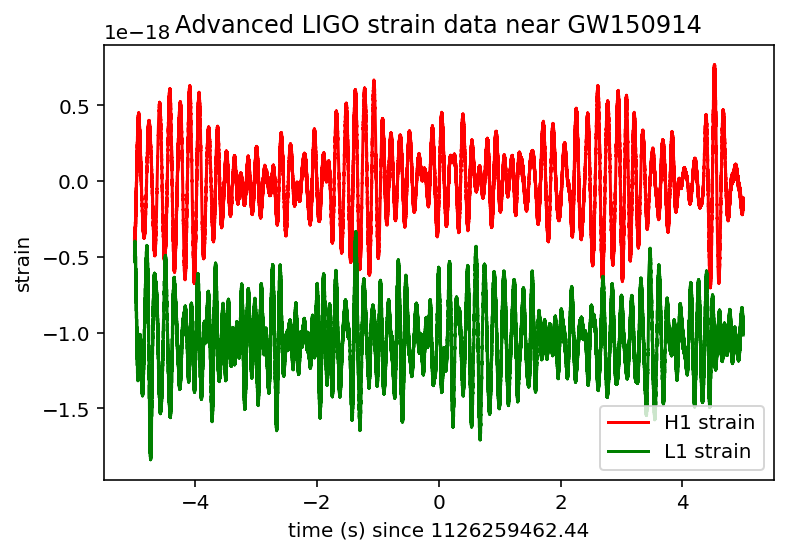

In [390]:
# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)    
    plt.savefig(eventname+'_strain.'+plottype)

First let's work with Hanford data to then evolve and work with Livingston. Starting by taking the FFT of the data and see what it gives us.

(40960,)


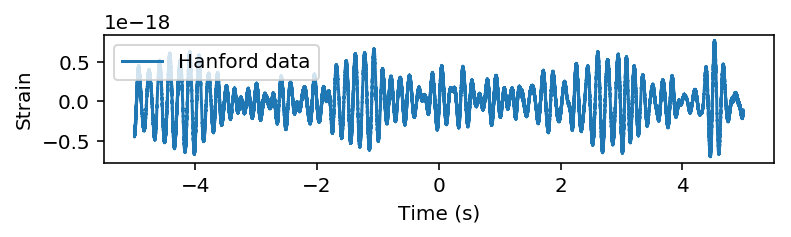

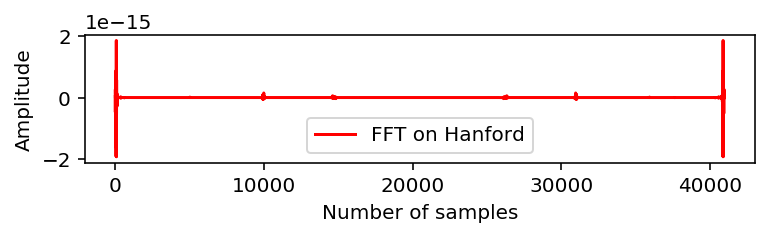

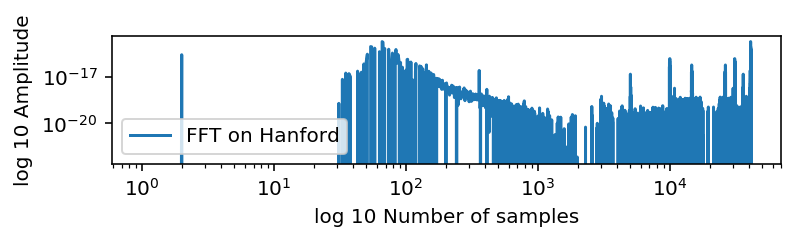

In [391]:
#These are the datapoints for h1.
h1 = strain_H1[indxt]
print (np.shape(h1))
th1 = time[indxt]- tevent

l1 = strain_L1[indxt]
tl1 = time[indxt]- tevent

ffth1 = np.fft.fft(h1)

fig = plt.figure()

plt.subplot(3, 1, 1)
plt.plot(th1,h1, label = 'Hanford data')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

plt.subplot(3, 1, 2)
plt.plot(ffth1, 'r', label = 'FFT on Hanford')
plt.legend()
plt.xlabel('Number of samples')
plt.ylabel('Amplitude')
plt.show()

plt.subplot(3, 1, 3)
plt.loglog(ffth1, label = 'FFT on Hanford')
plt.xlabel('log 10 Number of samples')
plt.ylabel('log 10 Amplitude')
plt.legend()
plt.show()

Indeed, there are many low-frequency components in the signal. Also, we'll need to guarantee small spectral leakage when we deal with the data. Thus, we will need to use a windowing function to avoid this effect and analyze the signal correctly. There are many options for windowing a function: Hamming, Hanning, Blackman-Harris and so on. We can start using a standard flattop window to analyze the data and see the output.

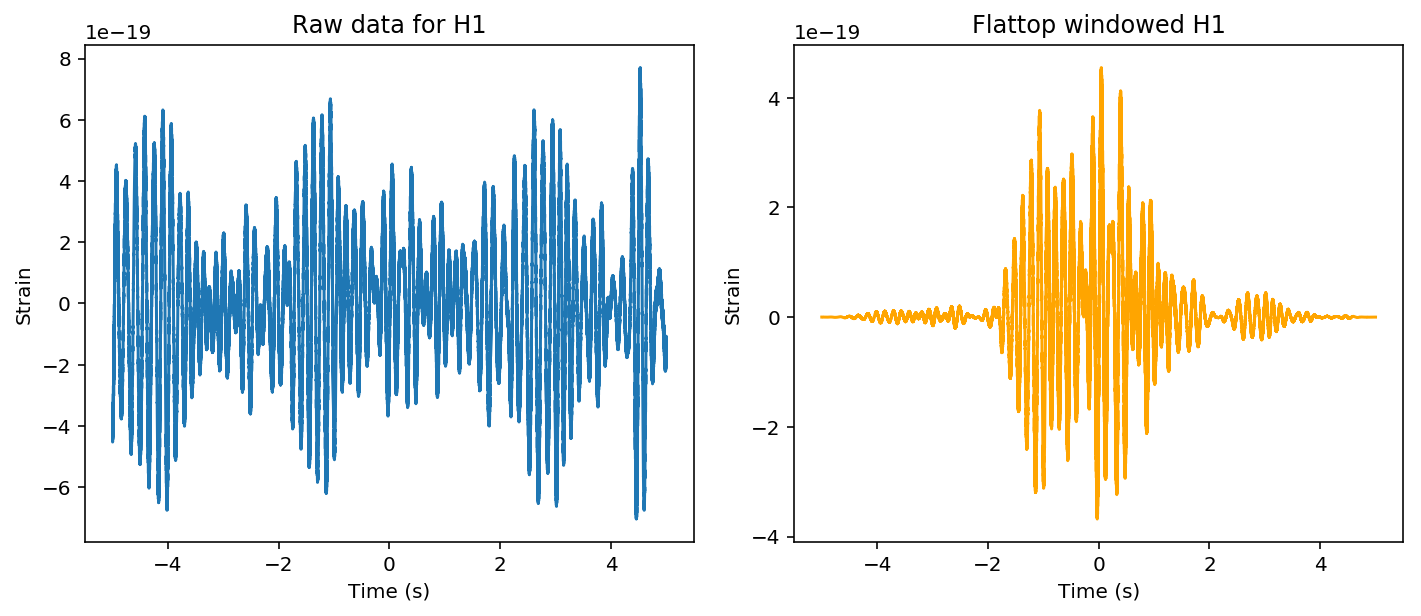

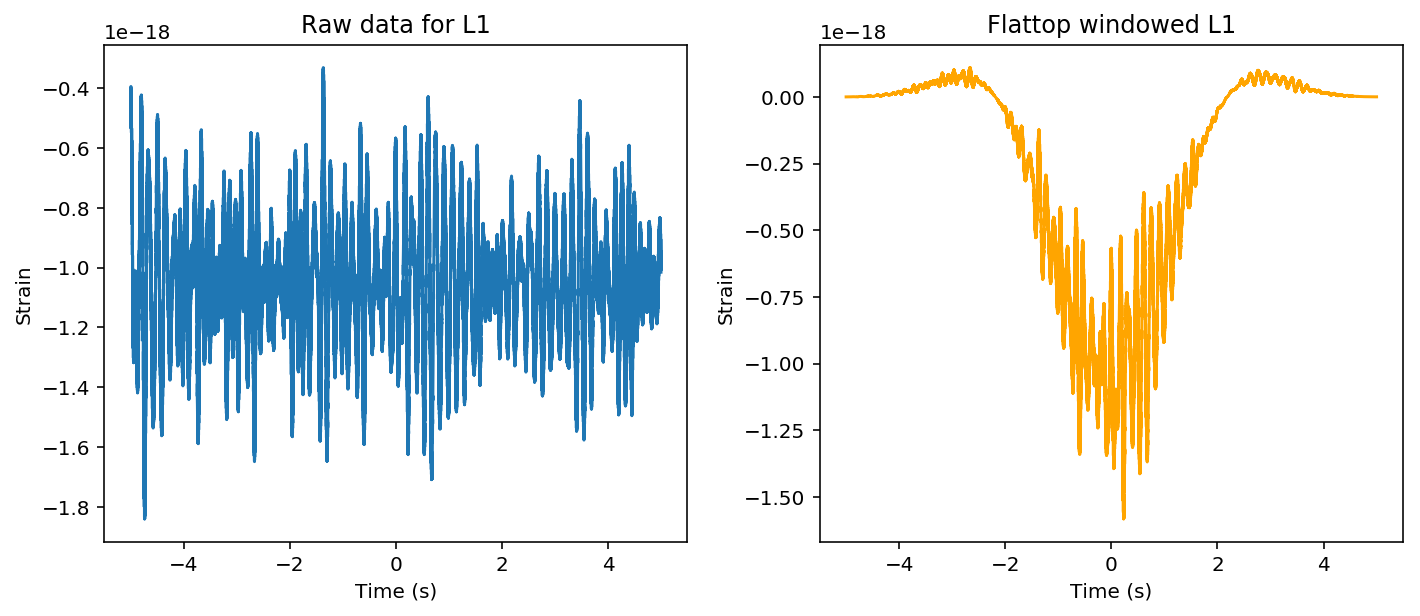

In [392]:
import numpy as np
import scipy
from scipy.signal import firwin, freqz, lfilter

def window(data, window_fn="hamming"):
    data = data * scipy.signal.get_window(window_fn,len(data))
    windowed_data = data
    return windowed_data

windowedh1 = window(h1, window_fn="flattop")
windowedl1 = window(l1,window_fn="flattop")
fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.plot(th1,h1)
plt.title("Raw data for H1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(th1,windowedh1,'orange')
plt.title("Flattop windowed H1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.show()

fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.plot(tl1,l1)
plt.title("Raw data for L1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(th1,windowedl1,'orange')
plt.title("Flattop windowed L1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.show()

Now we wish to compare the difference between these two. We can plot the Power Spectral densities for the raw data and the windowed data, which are defined as the absolute square value of the FFT. 
   \begin{equation}
   PSD(f)  = |FFT(f)^2|
   \end{equation}

Power spectral density function (PSD) shows the strength of the variations(energy) as a function of frequency. In other words, it shows at which frequencies variations are strong and at which frequencies variations are weak. The unit of PSD is energy per frequency(width) and you can obtain energy within a specific frequency range by integrating PSD within that frequency range.

## Hanford preliminaries

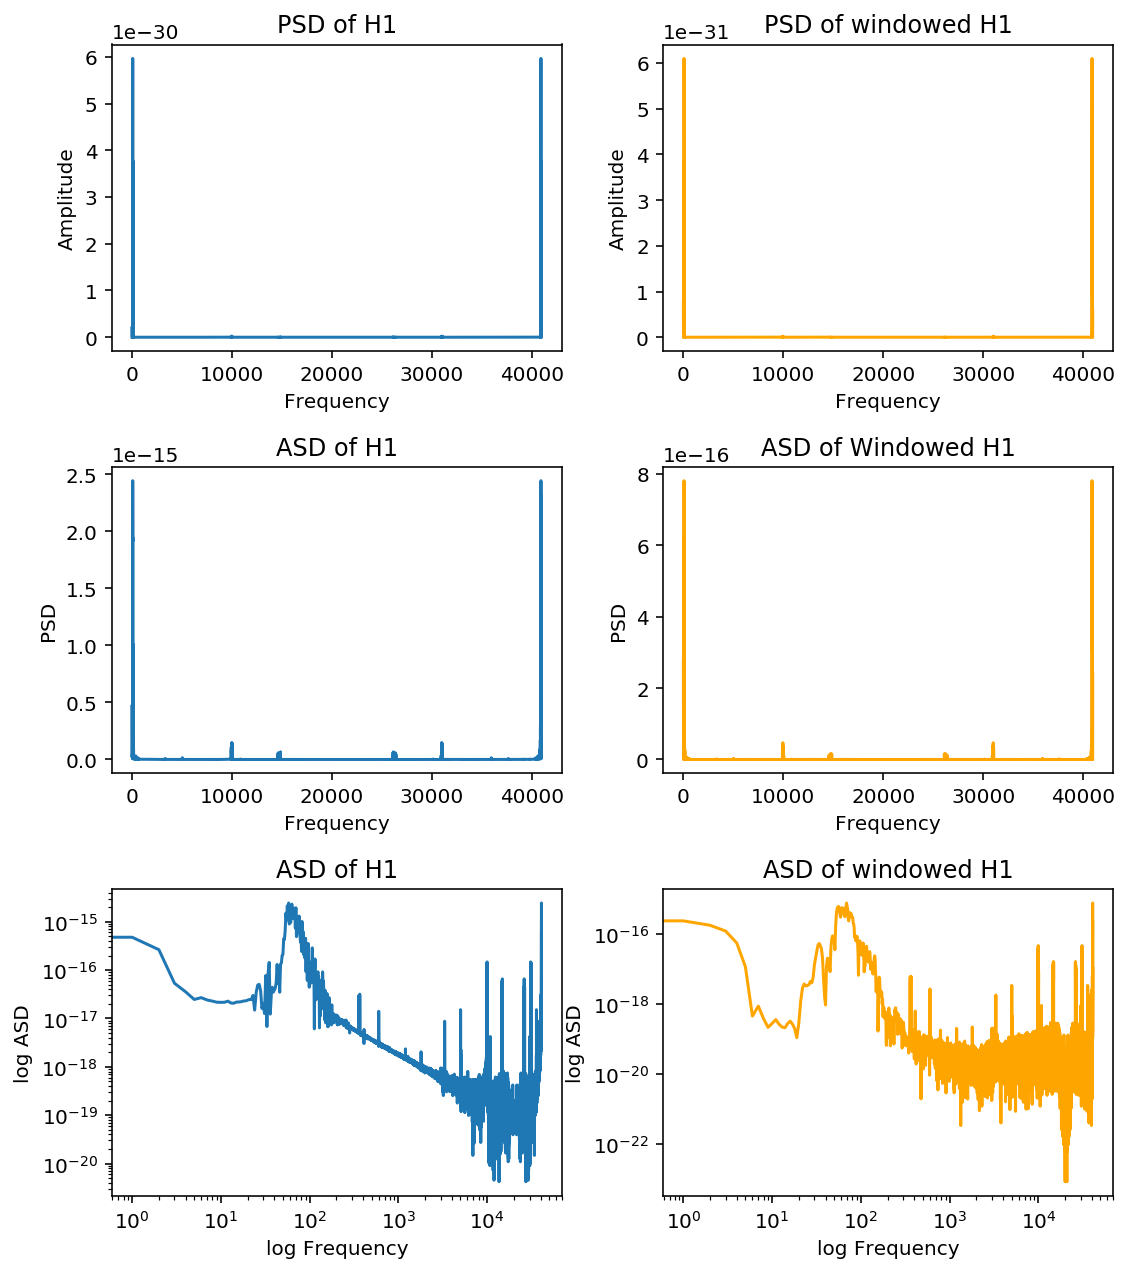

In [393]:
def ps(data):
    data = np.abs(np.fft.fft(data)**2)
    return data
# The ASDs are the square root of the power spectral densities (PSDs), 
#which are averages of the square of the fast fourier transforms (FFTs) of the data.

plt.figure(figsize=(8,9))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(3, 2, 1)
plt.title('PSD of H1')
plt.plot(ps(h1))
plt.xlabel('Frequency')
plt.tight_layout()
plt.ylabel('Amplitude')

plt.subplot(3, 2, 2)
plt.title('PSD of windowed H1')
plt.plot(ps(windowedh1),'orange')
plt.xlabel('Frequency')
plt.tight_layout()
plt.ylabel('Amplitude')


plt.subplot(3, 2, 3)
plt.title('ASD of H1')
plt.plot(np.sqrt(ps(h1)))
plt.xlabel('Frequency')
plt.tight_layout()
plt.ylabel('PSD' )


plt.subplot(3, 2, 4)
plt.title('ASD of Windowed H1')
plt.plot(np.sqrt(ps(windowedh1)),'orange')
plt.xlabel('Frequency')
plt.tight_layout()
plt.ylabel('PSD' )

plt.subplot(3,2, 5)
plt.title('ASD of H1')
plt.loglog(np.sqrt(ps(h1)))
plt.xlabel('log Frequency')
plt.tight_layout()
plt.ylabel('log ASD' )

plt.subplot(3,2,6)
plt.title('ASD of windowed H1')
plt.loglog(np.sqrt(ps(windowedh1)),'orange')
plt.xlabel('log Frequency')
plt.tight_layout()
plt.ylabel('log ASD' )
plt.show()
#Power spectral density function (PSD) shows the strength of the variations(energy) as a function of frequency. 
#In other words, it shows at which frequencies variations are strong and at which frequencies variations are weak. 
#The unit of PSD is energy per frequency(width) and you can obtain energy within 
#a specific frequency range by integrating PSD within that frequency range.

## Livingston preliminaries

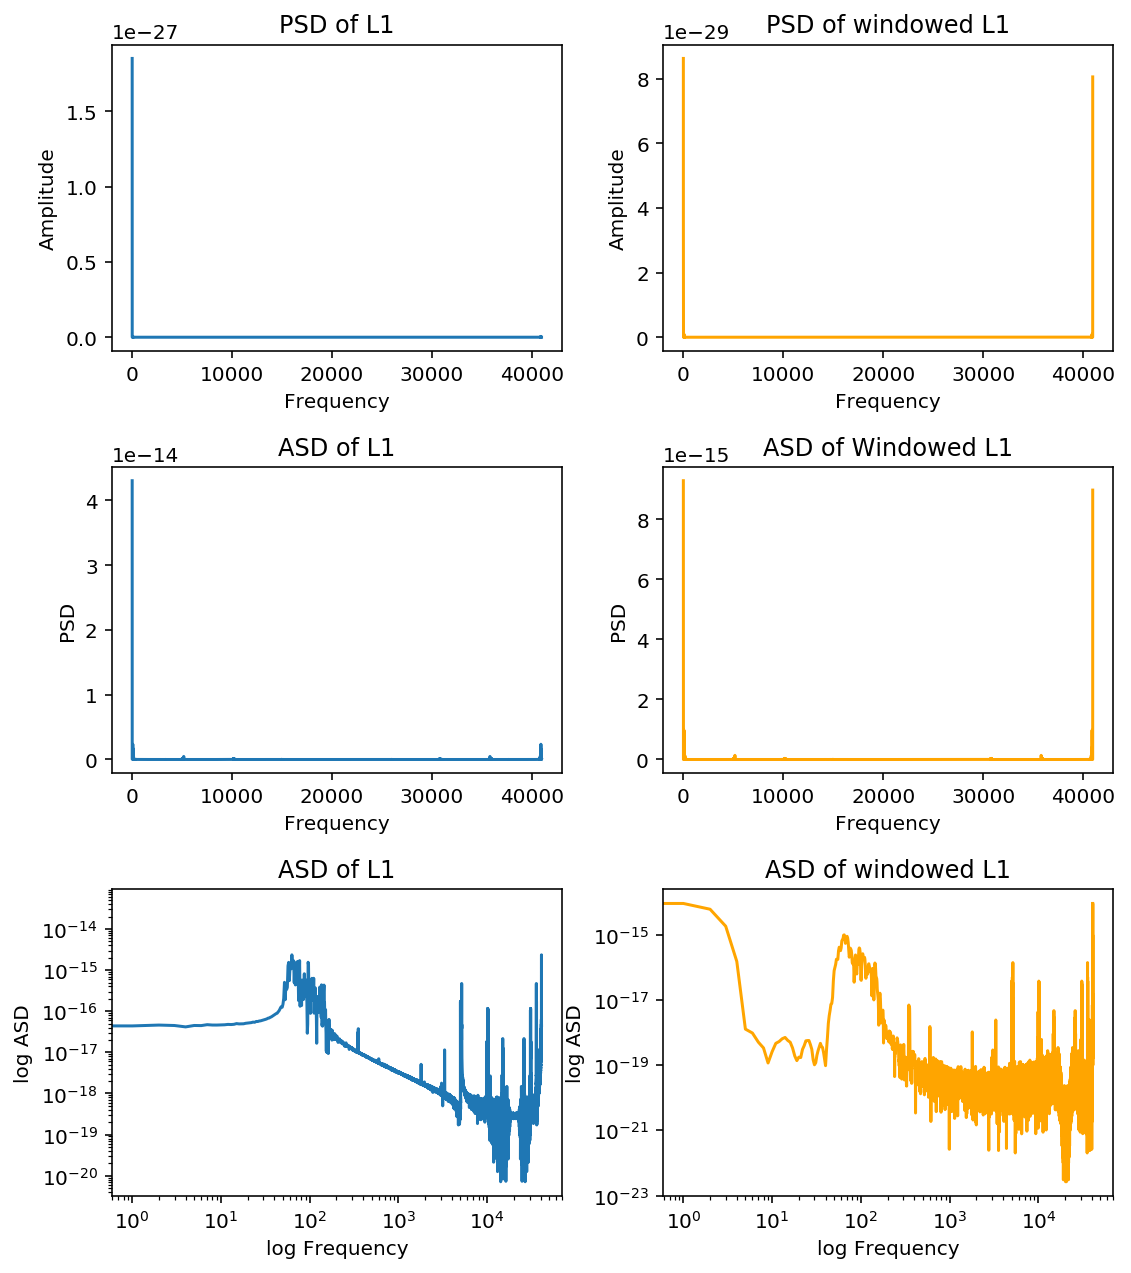

In [394]:
def ps(data):
    data = np.abs(np.fft.fft(data)**2)
    return data
# The ASDs are the square root of the power spectral densities (PSDs), 
#which are averages of the square of the fast fourier transforms (FFTs) of the data.

plt.figure(figsize=(8,9))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(3, 2, 1)
plt.title('PSD of L1')
plt.plot(ps(l1))
plt.xlabel('Frequency')
plt.tight_layout()
plt.ylabel('Amplitude')

plt.subplot(3, 2, 2)
plt.title('PSD of windowed L1')
plt.plot(ps(windowedl1),'orange')
plt.xlabel('Frequency')
plt.tight_layout()
plt.ylabel('Amplitude')

plt.subplot(3, 2, 3)
plt.title('ASD of L1')
plt.plot(np.sqrt(ps(l1)))
plt.xlabel('Frequency')
plt.tight_layout()
plt.ylabel('PSD' )


plt.subplot(3, 2, 4)
plt.title('ASD of Windowed L1')
plt.plot(np.sqrt(ps(windowedl1)),'orange')
plt.xlabel('Frequency')
plt.tight_layout()
plt.ylabel('PSD' )

plt.subplot(3,2, 5)
plt.title('ASD of L1')
plt.loglog(np.sqrt(ps(l1)))
plt.xlabel('log Frequency')
plt.tight_layout()
plt.ylabel('log ASD' )

plt.subplot(3,2,6)
plt.title('ASD of windowed L1')
plt.loglog(np.sqrt(ps(windowedl1)),'orange')
plt.xlabel('log Frequency')
plt.tight_layout()
plt.ylabel('log ASD' )
plt.show()
#Power spectral density function (PSD) shows the strength of the variations(energy) as a function of frequency. 
#In other words, it shows at which frequencies variations are strong and at which frequencies variations are weak. 
#The unit of PSD is energy per frequency(width) and you can obtain energy within 
#a specific frequency range by integrating PSD within that frequency range.

We can also compare the two spectograms to see that the windowing function helps 'clearing' some of the data in comparison to the raw data we had before. There are spectral differences in all timescales, for all frequencies. Specifically, in the spectral lines corresponding to the peaks we have observed in the ASD, we see accentuated differences when we take the residuals.

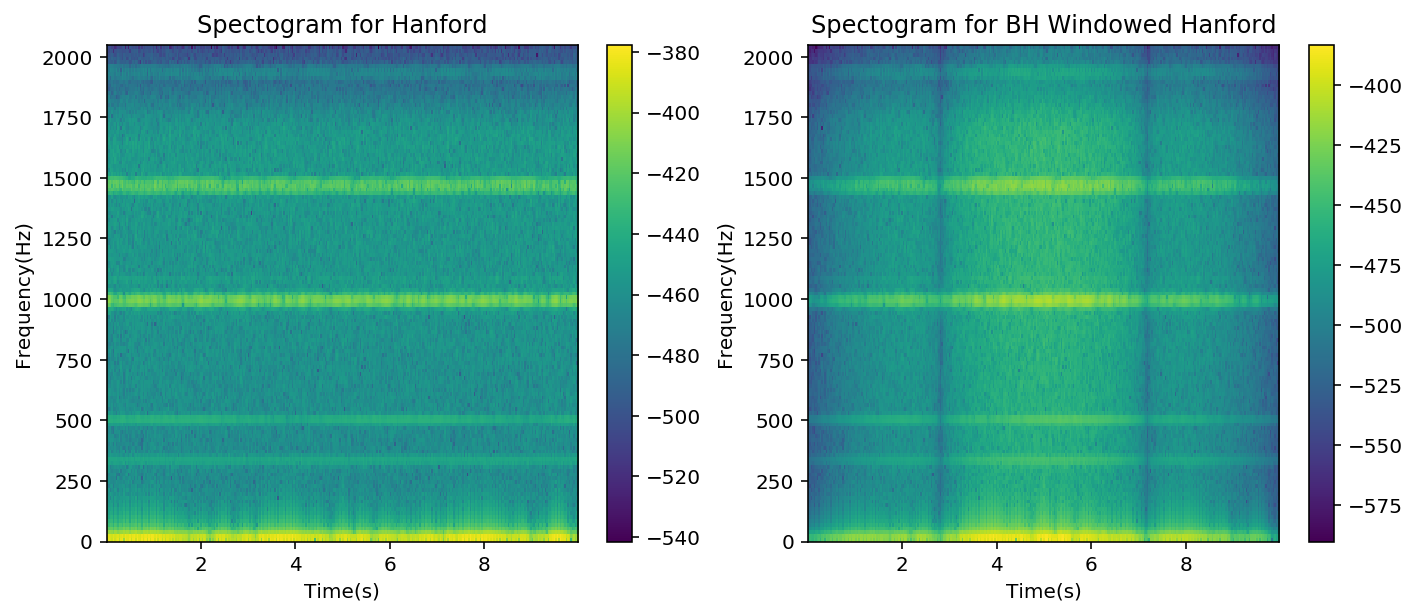

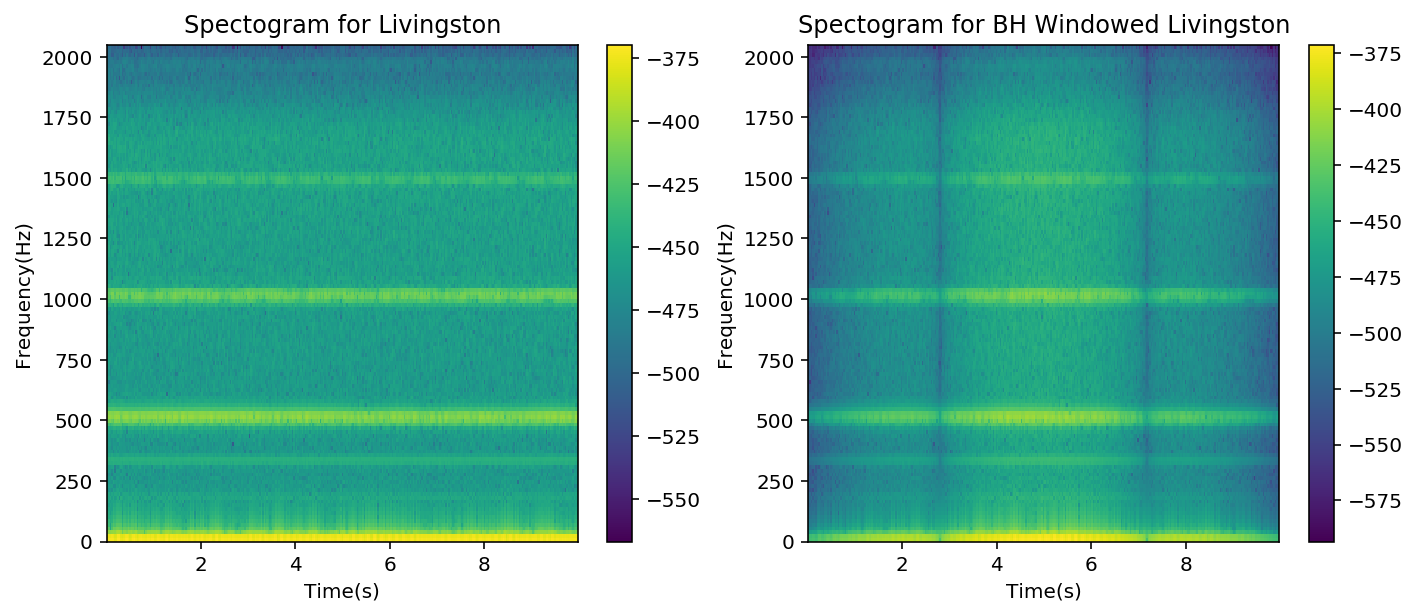

In [395]:
fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.specgram(h1,Fs=4096)
plt.title('Spectogram for Hanford')
plt.xlabel('Time(s)')
plt.colorbar()
plt.ylabel('Frequency(Hz)')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.specgram(windowedh1,Fs=4096)
plt.title('Spectogram for BH Windowed Hanford')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.tight_layout()
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.specgram(l1,Fs=4096)
plt.title('Spectogram for Livingston')
plt.xlabel('Time(s)')
plt.colorbar()
plt.ylabel('Frequency(Hz)')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.specgram(windowedl1,Fs=4096)
plt.title('Spectogram for BH Windowed Livingston')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.tight_layout()
plt.colorbar()
plt.show()

In these spectrograms, we cannot see anything that resembles a gravitational wave. This is because we just applied a the Fourier transform after applying a window -- we have not done anything regarding the noise/data relation so far, and this is the point where mentioning how noise behaves both in time and frequency domain will help us get a better sense of what is in fact happening and how to properly find gravitational waves. Up to this point, we were able to calculate the power spectral density (PSD) directly, without inferring about noise reductions to explicit the data properly.

# Generalities dealing with data and SNR

When dealing with the LIGO data, we wish to create a matched filter algorithm in order to identify gravitational waves. As we have seen before, a key operation to be applied towards experimental data is to make sure we do not obtain spectral leakage problems -- this is why we have applied a Blackman Harris window to the data in the first place.

Now, when building the model, we can think in terms of the most general relations possible. First, if our model is assumed good, we can deal it as a matrix operation in a first approximation, to which when we compare the model we're trying to implement to the actual data, we're making a $\chi^2$ computation. In linear algebra language, that means we're minimizing the following relation: $ \chi^2 = (d-A(m))^T N^{-1} (d-A(m)) $. In our specific case, the best-fit general model is the one that minimizes this quantity. In order to calculate that, we can simply take the first derivative of this function and make it equal to zero. An important note is that in this case we consider our model is not a non-linear model, which means we can consider $A(m) = Am$, a linear model. We get then that this "best model" should respect the following condition: $m=(A^TN^{-1}d)(A^TN^{-1}A)^{-1}$. 

For the purposes of this specific problem, $m$ is the ${best signal}$ corresponding to the matched filter algorithm we're looking for, $N^{-1}$ corresponds to our noise model and $A$ the template we get from LIGO. What we're trying to do is simply take the values of $A$ and seeking for a possible best-matched signal that will correspond to the signal of a gravitational wave. This means we're looking for the gravitational wave among a huge amount of noise, but if we ever find a best-fit for it in the signal (data $d$), that will be a measurable quantity and represent an actual feature.
 
 The rest of the method is described in the Latex file.

Following what we get for the matched filter method, first we define the template that will be used, template_p. Then, we move further to calculate the PSD of the Hanford data. Not only the PSD is sufficient: we also need to smooth the spectrum in order to eliminate other non-physical signals that we can see in the data! Our objective is to match the template with an actual black merger signature. 

For the Hanford event, we will use a gaussian smoothing filter as a noise model. For Livingston, we will use a medfilter function that will perform an average sweep on all values in the spectrum, and apply it to all data.

## Hanford matched filter 

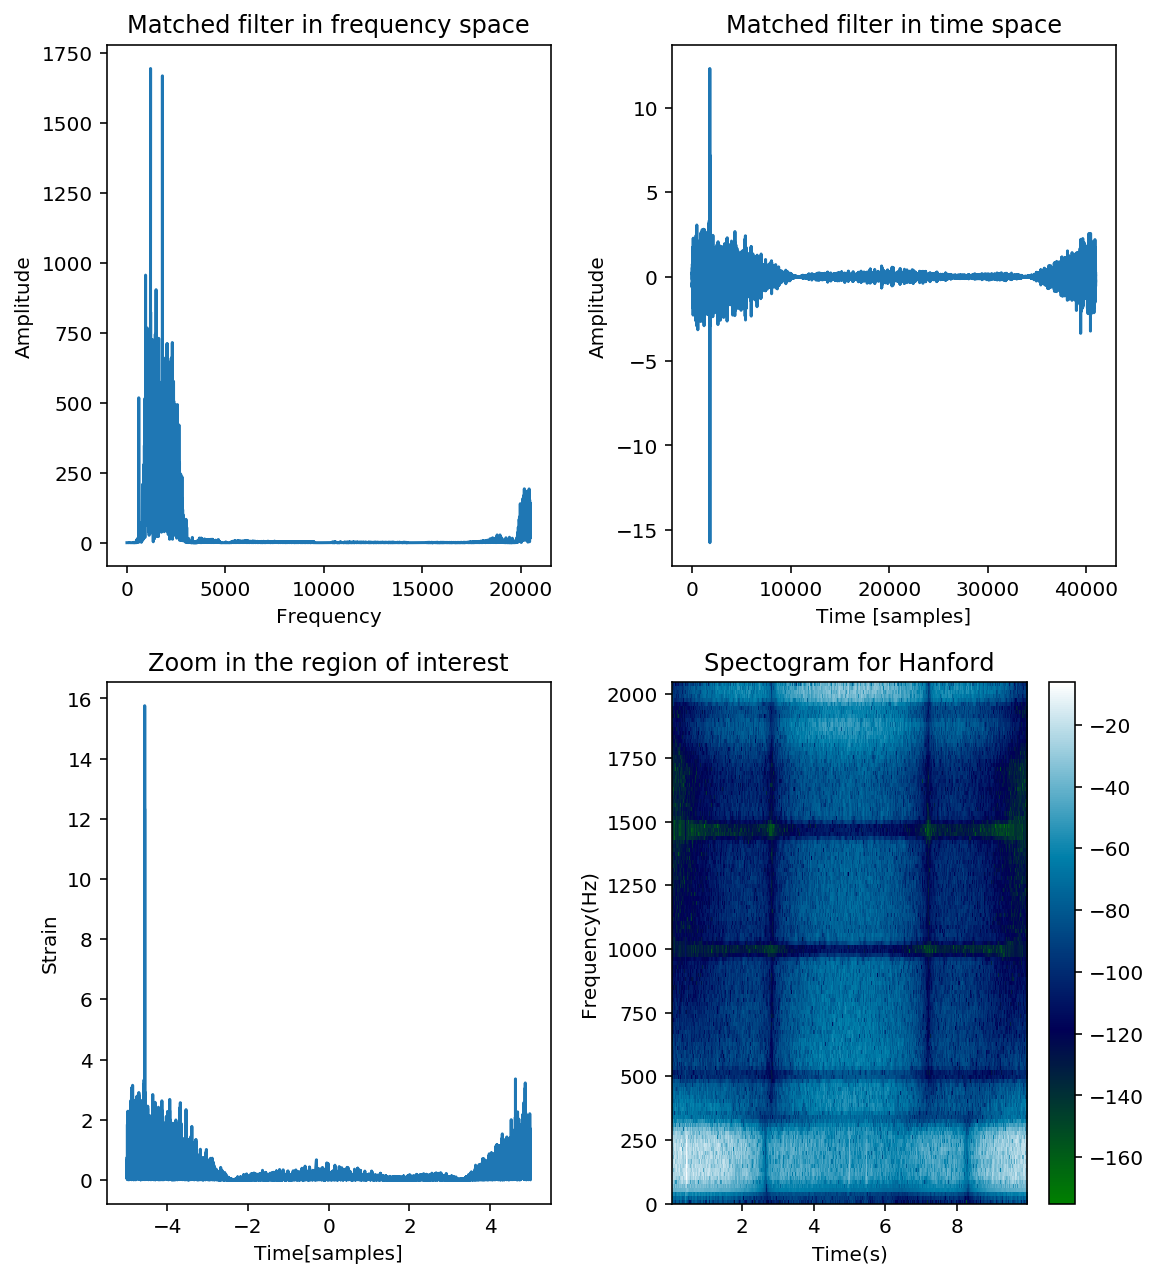

In [396]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()
    
bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

from scipy.ndimage import gaussian_filter

#Calculating the PSD of the windowed data 
psd_data = np.abs(np.fft.rfft(windowedh1))**2

def smoothing_data(data):
    data = gaussian_filter(data,100)
    return data

#Smooth the PSD -> This is my noise model!!
noise = smoothing_data(psd_data)

#Let us do the same thing about the template!
np.shape(template_p)
#Taking the Complex Conjugate
temp_fft = np.conj(np.fft.rfft(template_p[indxt]))

whitened_template = temp_fft/np.sqrt(noise)
whitened_data = np.fft.rfft(windowedh1)/(np.sqrt(noise))

matched_filter = whitened_template * whitened_data
matched_irfft = np.fft.irfft(matched_filter)

spec_cmap='ocean'

plt.figure(figsize=(8,9))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(2, 2, 1)
plt.plot(np.abs(matched_filter))
plt.title('Matched filter in frequency space')
plt.tight_layout()
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(matched_irfft)
plt.title('Matched filter in time space')
plt.xlabel('Time [samples]')
plt.tight_layout()
plt.ylabel('Amplitude')

plt.subplot(2, 2, 3)
plt.title('Zoom in the region of interest')
plt.plot(th1,np.abs(matched_irfft))
#plt.xlim(0,2000)
plt.tight_layout()
plt.xlabel('Time[samples]')
plt.tight_layout()
plt.ylabel('Strain')

# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = int(fs/16.0)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15/16.0)

window = signal.blackmanharris(NFFT)
plt.subplot(2,2,4)
plt.specgram(matched_irfft,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Hanford')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.tight_layout()
plt.colorbar()
plt.show()

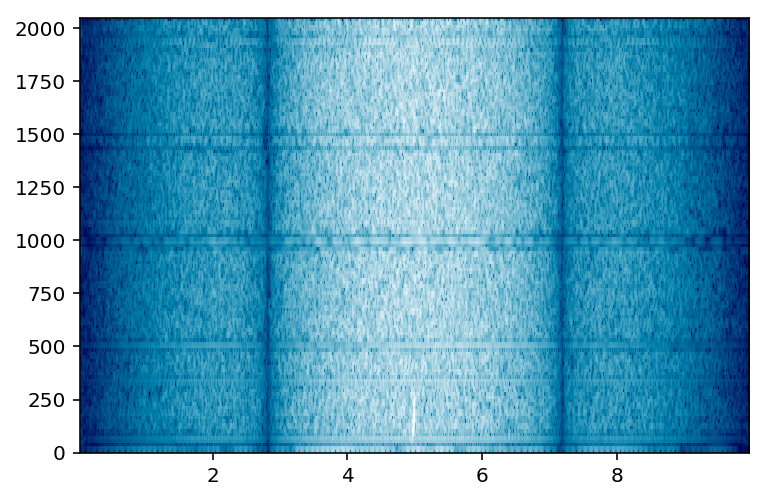

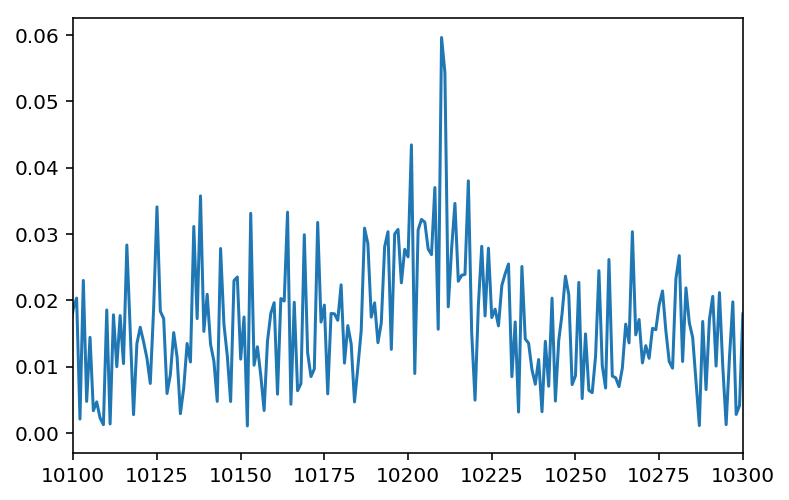

In [397]:

#We can see clues for the GW even in the normal spectogram!
plt.specgram(np.fft.irfft(whitened_data),Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.show()
plt.plot(np.abs(np.fft.ifft(whitened_data)))
plt.xlim(10100,10300)
plt.show()

Yes!! We can visualize the gravitation waves and confirm our predictions by using the spectogram to observe where in time the event occurred. Now we can repeat the same process for Livingston. 

## Livingston matched filter 

The method we will use for smoothing our PSD (noise) now will be applying a mean filter around this spectrum. The result will take into account the mean value distribution and then apply it to all bins we have in our PSD. 

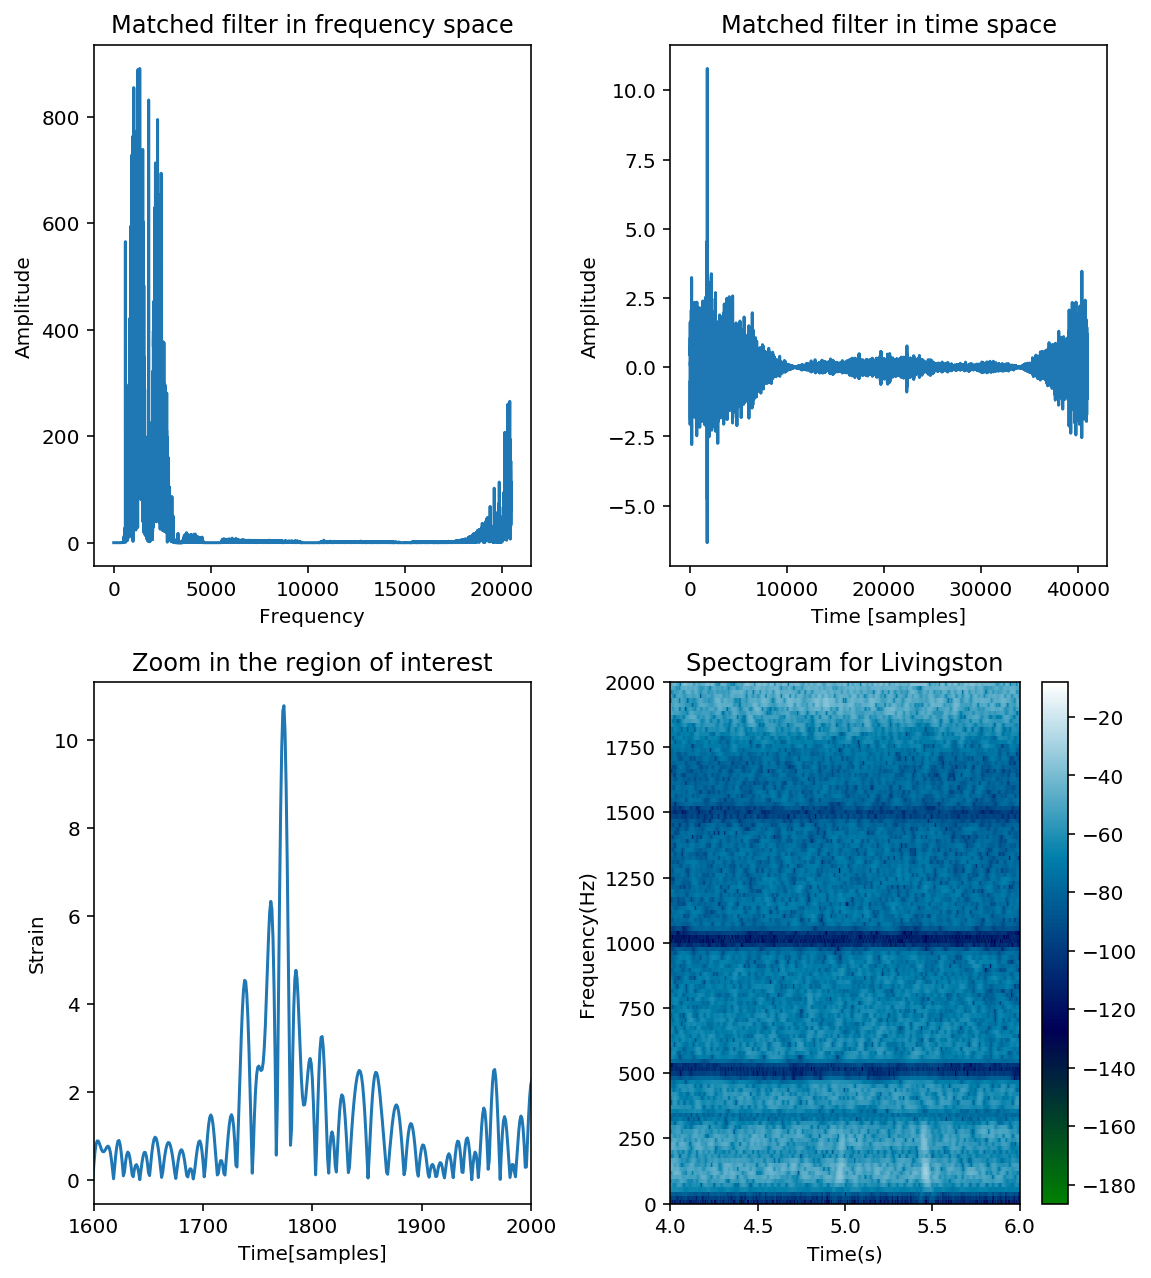

In [398]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()
    
bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

from scipy.ndimage import gaussian_filter

#Calculating the PSD of the windowed data 
psd_data = signal.medfilt(np.abs(np.fft.rfft(windowedl1))**2)

def smoothing_data(data):
    data = gaussian_filter(data,100)
    return data

#Smooth the PSD -> This is my noise model!!
noise = smoothing_data(psd_data)

#Let us do the same thing about the template!
np.shape(template_p)
#Taking the Complex Conjugate
temp_fft = np.conj(np.fft.rfft(template_p[indxt]))

whitened_template = temp_fft/np.sqrt(noise)
whitened_data = np.fft.rfft(windowedl1)/(np.sqrt(noise))

matched_filter2 = np.conj((np.fft.rfft(template_p[indxt]))/np.sqrt(noise))* whitened_data
matched_irfft2 = np.fft.irfft(matched_filter2)

spec_cmap='ocean'

plt.figure(figsize=(8,9))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(2, 2, 1)
plt.plot(np.abs(matched_filter2))
plt.title('Matched filter in frequency space')
plt.tight_layout()
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(matched_irfft2)
plt.title('Matched filter in time space')
plt.xlabel('Time [samples]')
plt.tight_layout()
plt.ylabel('Amplitude')

plt.subplot(2, 2, 3)
plt.title('Zoom in the region of interest')
plt.plot(np.abs(matched_irfft2))
plt.tight_layout()
plt.xlabel('Time[samples]')
plt.tight_layout()
plt.ylabel('Strain')
plt.xlim(1600,2000)

# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = int(fs/16.0)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15/16.0)

plt.subplot(2,2,4)
plt.specgram(matched_irfft2,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Livingston')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.axis([4,6,0,2000])
plt.tight_layout()
plt.colorbar()
plt.show()

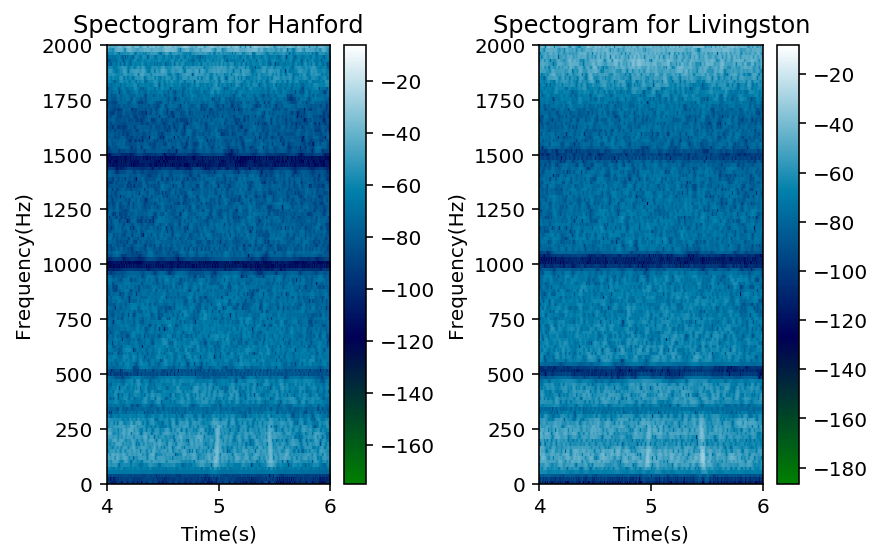

In [399]:
plt.savefig('events.png')
plt.subplot(1,2,1)
plt.specgram(matched_irfft,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Hanford')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.axis([4,6,0,2000])
plt.tight_layout()
plt.colorbar()

plt.subplot(1,2,2)
plt.specgram(matched_irfft2,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Livingston')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.axis([4,6,0,2000])
plt.tight_layout()
plt.colorbar()
plt.savefig('events.png')
plt.show()

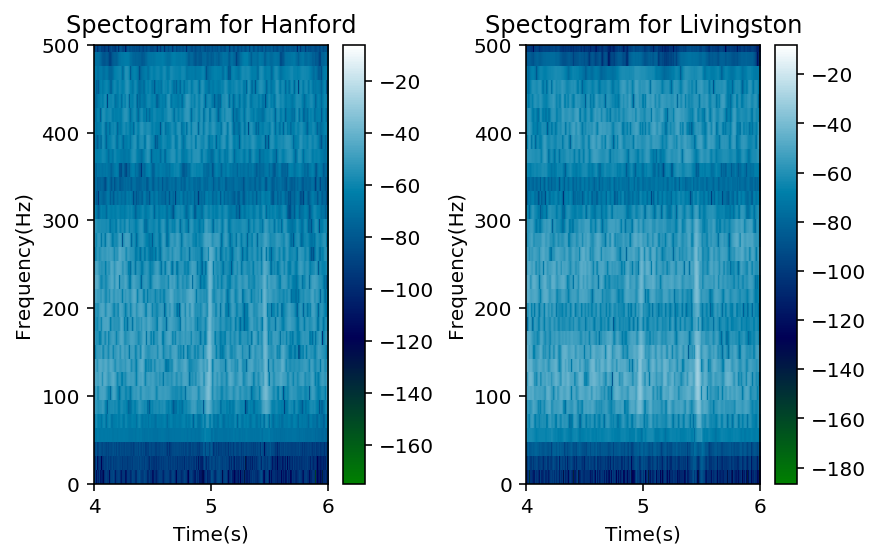

In [400]:
plt.savefig('events.png')
plt.subplot(1,2,1)
plt.specgram(matched_irfft,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Hanford')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.axis([4,6,0,500])
plt.tight_layout()
plt.colorbar()

plt.subplot(1,2,2)
plt.specgram(matched_irfft2,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Livingston')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.axis([4,6,0,500])
plt.tight_layout()
plt.colorbar()
plt.savefig('events2.png')
plt.show()

## SNR

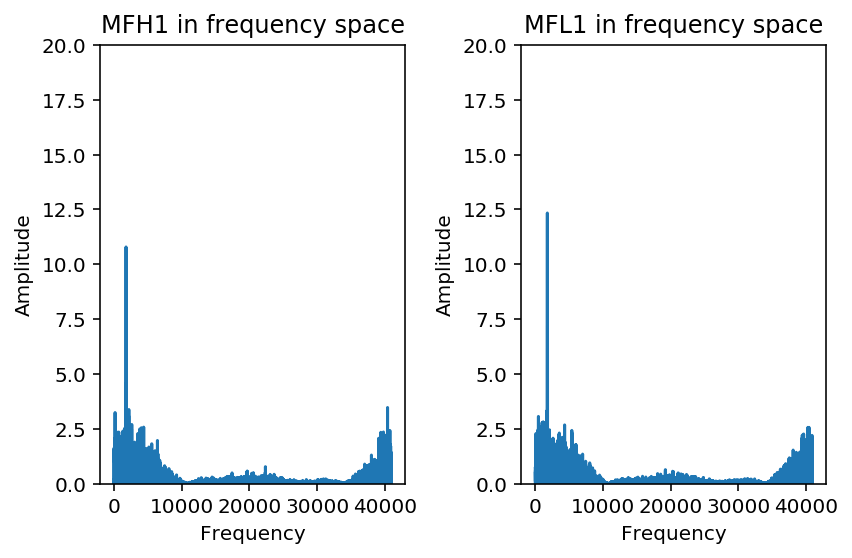

In [401]:
plt.subplot(1,2,1)
plt.plot(matched_irfft2)

plt.title('MFH1 in frequency space')
plt.ylim(0,20)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(matched_irfft)
plt.title('MFL1 in frequency space')
plt.ylim(0,20)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.tight_layout()

plt.savefig('event1SNR.png')
plt.show()


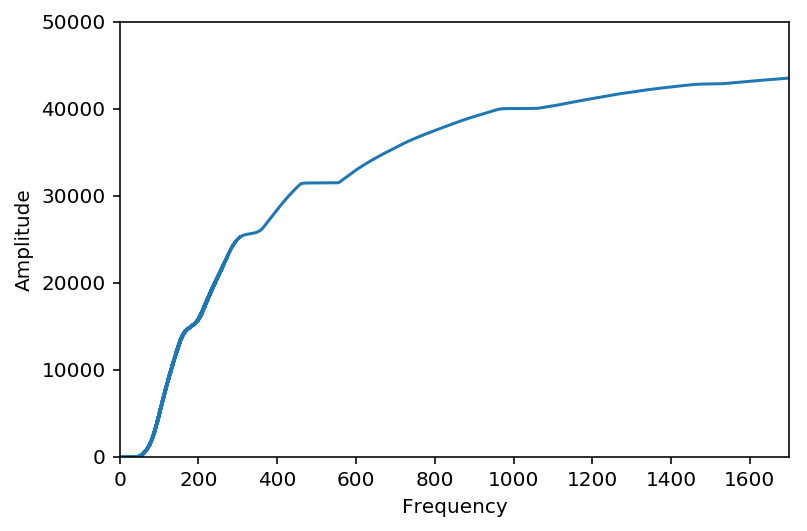

In [402]:
freq_H = np.fft.rfftfreq(th1.shape[-1], d=dt)
temp_sum_H = np.abs(np.cumsum(whitened_template))

plt.plot(freq_H,temp_sum_H)
plt.ylabel('Amplitude')
plt.xlim(0,1700)
plt.ylim(0,50000)
plt.xlabel('Frequency')
plt.savefig('CumsumEv1.png')

# Event 2

Reading in parameters for event GW151226
{u'fband': [43.0, 800.0], u'approx': u'lalsim.SEOBNRv2', u'fs': 4096, u'name': u'GW151226', u'utcevent': u'2015-12-26T03:38:53.65', u'fn_H1': u'H-H1_LOSC_4_V2-1135136334-32.hdf5', u'a1': 0.3998, u'fn_L1': u'L-L1_LOSC_4_V2-1135136334-32.hdf5', u'm1': 19.6427, u'f_min': 10.0, u'fn_template': u'GW151226_4_template.hdf5', u'm2': 6.7054, u'tevent': 1135136350.65, u'a2': -0.0396}
('time_H1: len, min, mean, max = ', 131072, 1135136334.0, 1135136349.999878, 1135136365.9997559)
('strain_H1: len, min, mean, max = ', 131072, -6.472207297567626e-19, -1.3912175037938857e-21, 6.419239604614273e-19)
('strain_L1: len, min, mean, max = ', 131072, -3.552827791530633e-18, -1.1312342249363738e-18, 1.3189604227431438e-18)
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA
1135136350.65


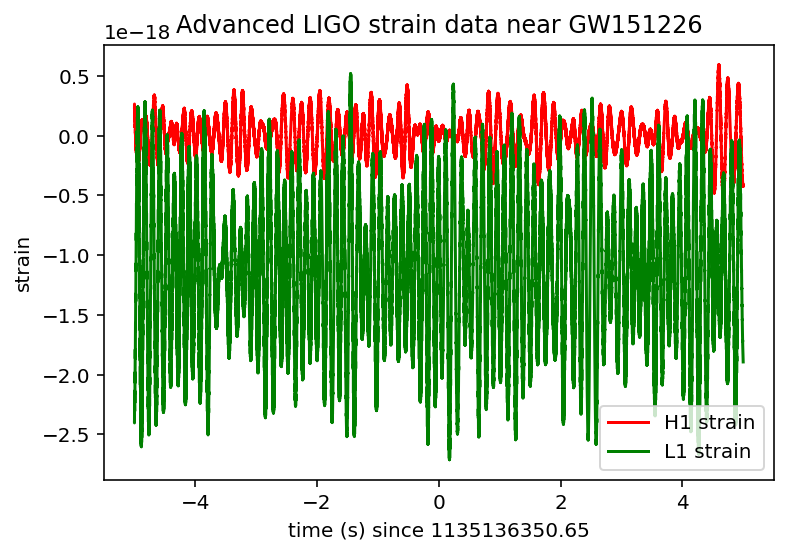

In [403]:
#-- SET ME   Tutorial should work with most binary black hole events
#-- Default is no event selection; you MUST select one to proceed.
#eventname = 'GW150914' 
eventname = 'GW151226' 
#eventname = 'LVT151012'
#eventname = 'GW170104'

# want plots?
make_plots = 1
plottype = "png"
#plottype = "pdf"

# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))

# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)    
    plt.savefig(eventname+'_strain.'+plottype)

(40960,)


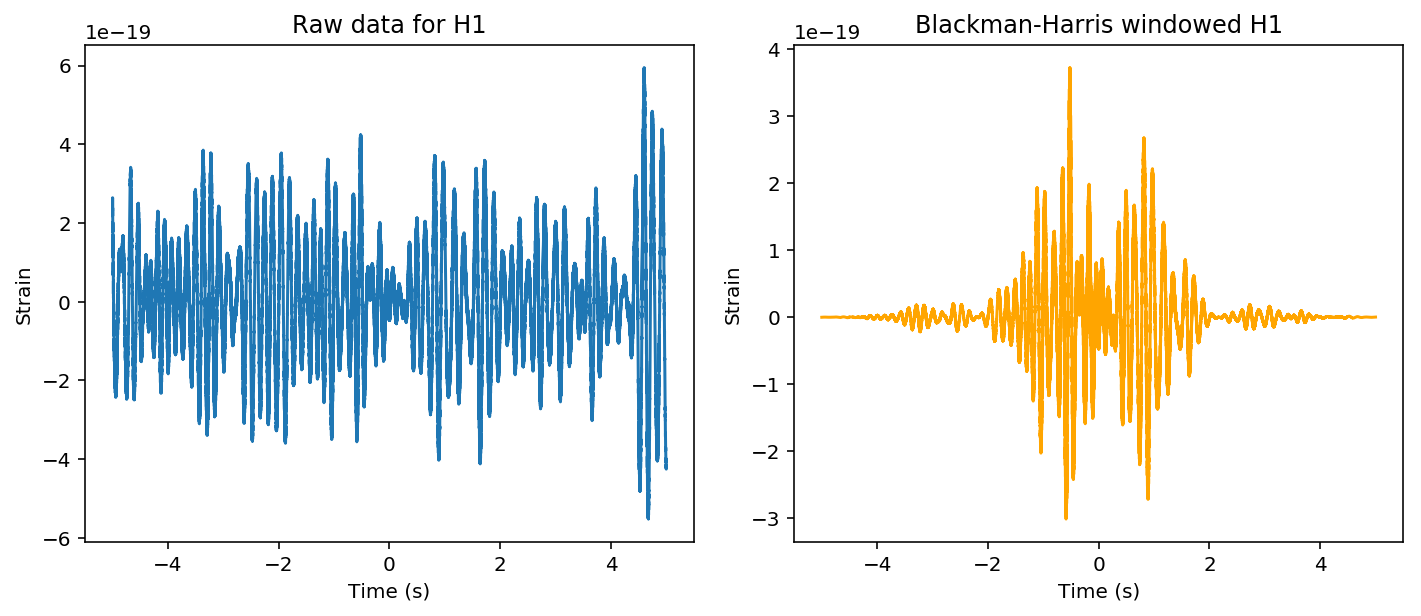

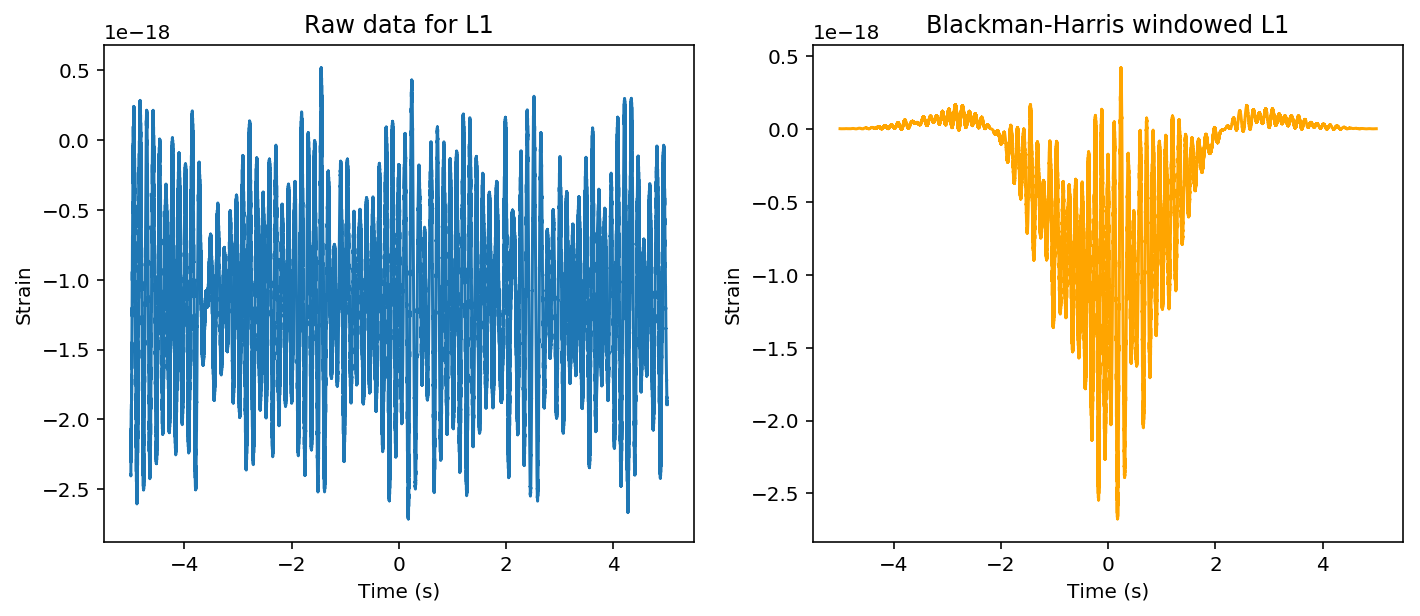

In [404]:
h1 = strain_H1[indxt]
print (np.shape(h1))
th1 = time[indxt]- tevent

l1 = strain_L1[indxt]
tl1 = time[indxt]- tevent

import numpy as np
import scipy
from scipy.signal import firwin, freqz, lfilter

def window(data, window_fn="flattop"):
    data = data * scipy.signal.get_window(window_fn,len(data))
    windowed_data = data
    return windowed_data

windowedh1 = window(h1, window_fn="flattop")
windowedl1 = window(l1,window_fn="flattop")
fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.plot(th1,h1)
plt.title("Raw data for H1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(th1,windowedh1,'orange')
plt.title("Blackman-Harris windowed H1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.show()

fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.plot(tl1,l1)
plt.title("Raw data for L1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(th1,windowedl1,'orange')
plt.title("Blackman-Harris windowed L1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.show()

## Hanford matched filter

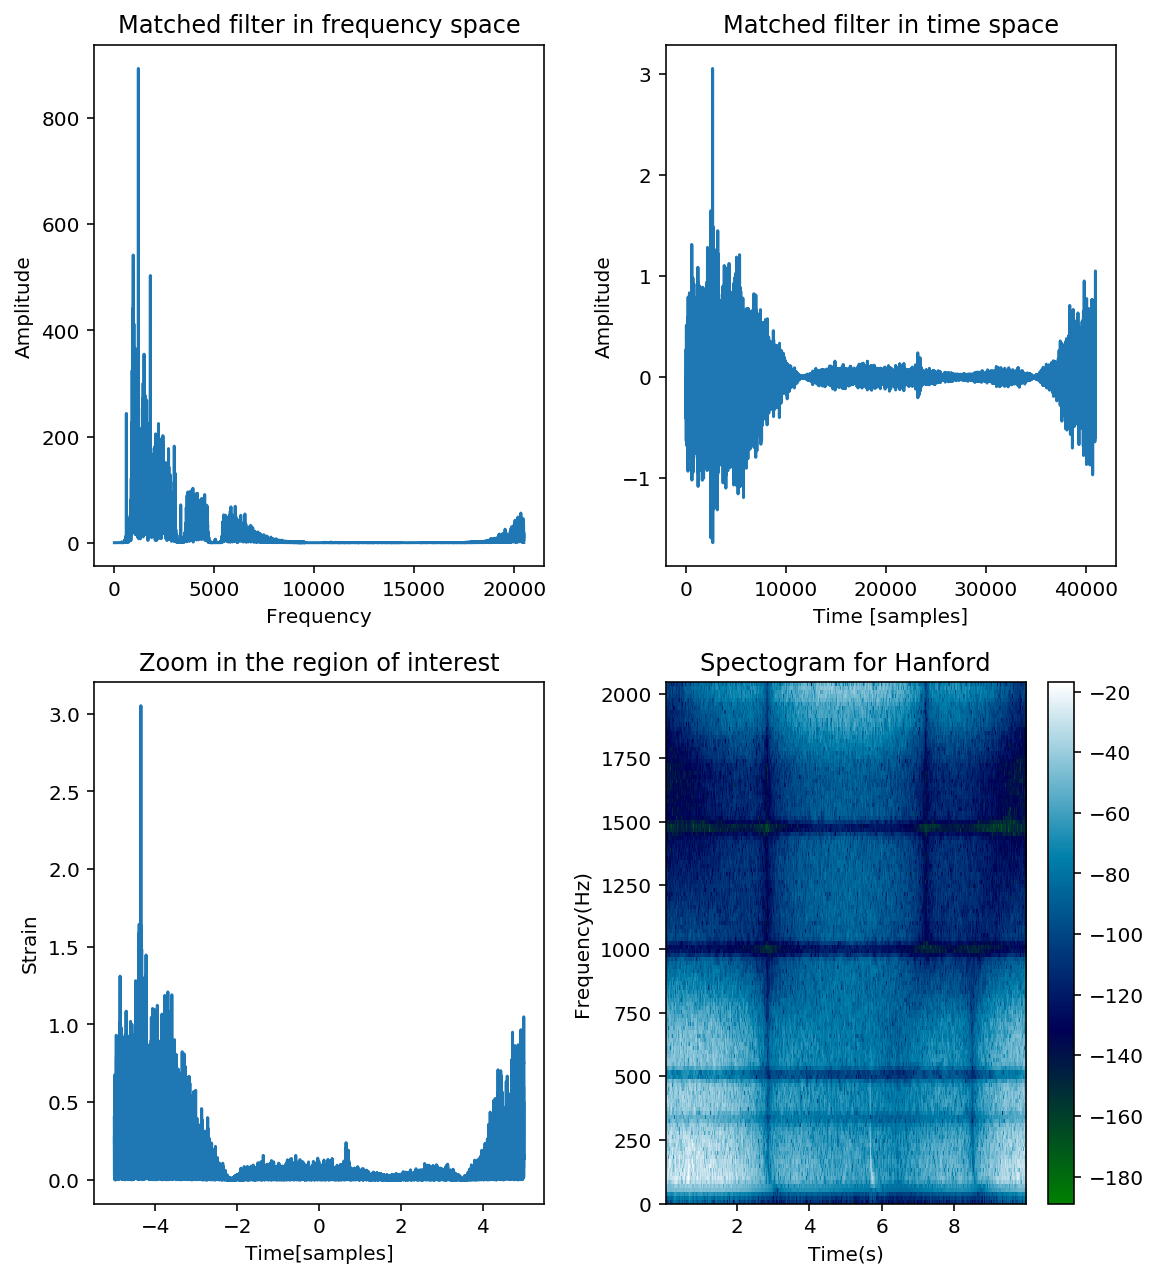

In [405]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()
    
bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

from scipy.ndimage import gaussian_filter

#Calculating the PSD of the windowed data 
psd_data = np.abs(np.fft.rfft(windowedh1))**2

def smoothing_data(data):
    data = gaussian_filter(data,100)
    return data

#Smooth the PSD -> This is my noise model!!
noise = smoothing_data(psd_data)

#Let us do the same thing about the template!
np.shape(template_p)
#Taking the Complex Conjugate
temp_fft = np.conj(np.fft.rfft(template_p[indxt]))

whitened_template = temp_fft/np.sqrt(noise)
whitened_data = np.fft.rfft(windowedh1)/(np.sqrt(noise))

matched_filter = whitened_template * whitened_data
matched_irfft = np.fft.irfft(matched_filter)

spec_cmap='ocean'

plt.figure(figsize=(8,9))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(2, 2, 1)
plt.plot(np.abs(matched_filter))
plt.title('Matched filter in frequency space')
plt.tight_layout()
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(matched_irfft)
plt.title('Matched filter in time space')
plt.xlabel('Time [samples]')
plt.tight_layout()
plt.ylabel('Amplitude')

plt.subplot(2, 2, 3)
plt.title('Zoom in the region of interest')
plt.plot(th1,np.abs(matched_irfft))
#plt.xlim(0,2000)
plt.tight_layout()
plt.xlabel('Time[samples]')
plt.tight_layout()
plt.ylabel('Strain')

# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = int(fs/16.0)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15/16.0)

plt.subplot(2,2,4)
plt.specgram(matched_irfft,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Hanford')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.tight_layout()
plt.colorbar()
plt.show()

## Livingston matched filter

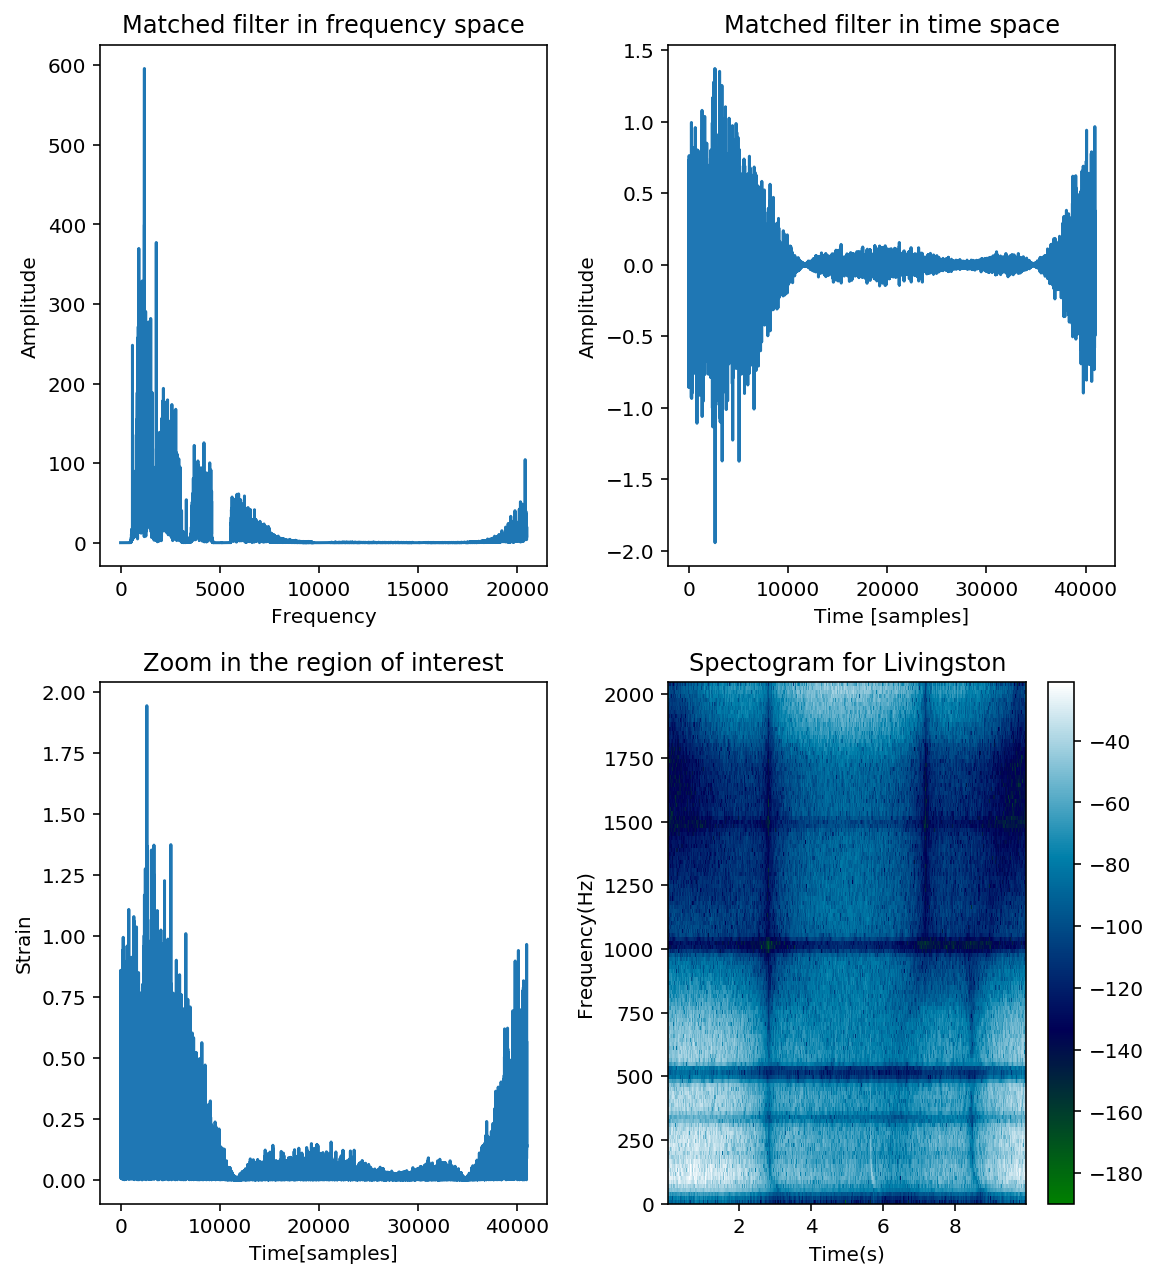

In [406]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()
    
bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

from scipy.ndimage import gaussian_filter

#Calculating the PSD of the windiwed data 
psd_data = signal.medfilt(np.abs(np.fft.rfft(windowedl1))**2)

def smoothing_data(data):
    data = gaussian_filter(data,100)
    return data

#Smooth the PSD -> This is my noise model!!
noise = smoothing_data(psd_data)

#Let us do the same thing about the template!
np.shape(template_p)
#Taking the Complex Conjugate
temp_fft = np.conj(np.fft.rfft(template_p[indxt]))

whitened_template = temp_fft/np.sqrt(noise)
whitened_data = np.fft.rfft(windowedl1)/(np.sqrt(noise))

matched_filter2 = np.conj((np.fft.rfft(template_p[indxt]))/np.sqrt(noise))* whitened_data
matched_irfft2 = np.fft.irfft(matched_filter2)

spec_cmap='ocean'

plt.figure(figsize=(8,9))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(2, 2, 1)
plt.plot(np.abs(matched_filter2))
plt.title('Matched filter in frequency space')
plt.tight_layout()
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(matched_irfft2)
plt.title('Matched filter in time space')
plt.xlabel('Time [samples]')
plt.tight_layout()
plt.ylabel('Amplitude')

plt.subplot(2, 2, 3)
plt.title('Zoom in the region of interest')
plt.plot(np.abs(matched_irfft2))
plt.tight_layout()
plt.xlabel('Time[samples]')
plt.tight_layout()
plt.ylabel('Strain')

# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = int(fs/16.0)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15/16.0)

window = signal.blackmanharris(NFFT)
plt.subplot(2,2,4)
plt.specgram(matched_irfft2,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Livingston')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.tight_layout()
plt.colorbar()
plt.show()

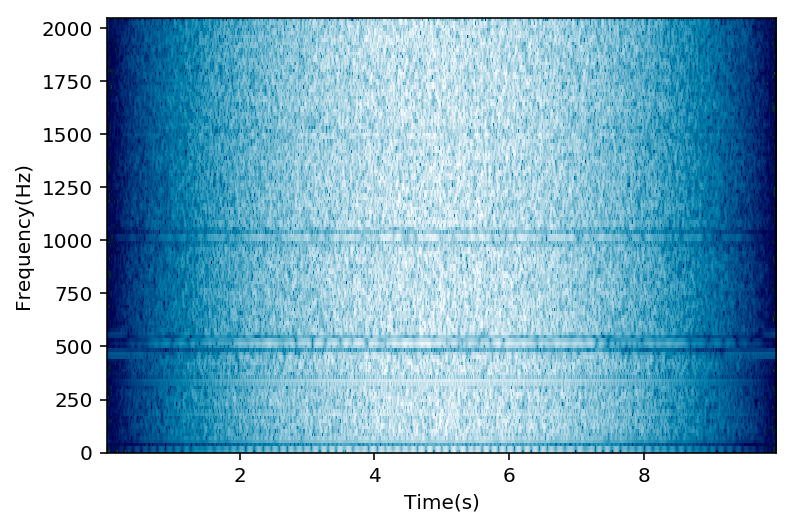

In [406]:
plt.specgram(np.fft.irfft(whitened_data),Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.show()

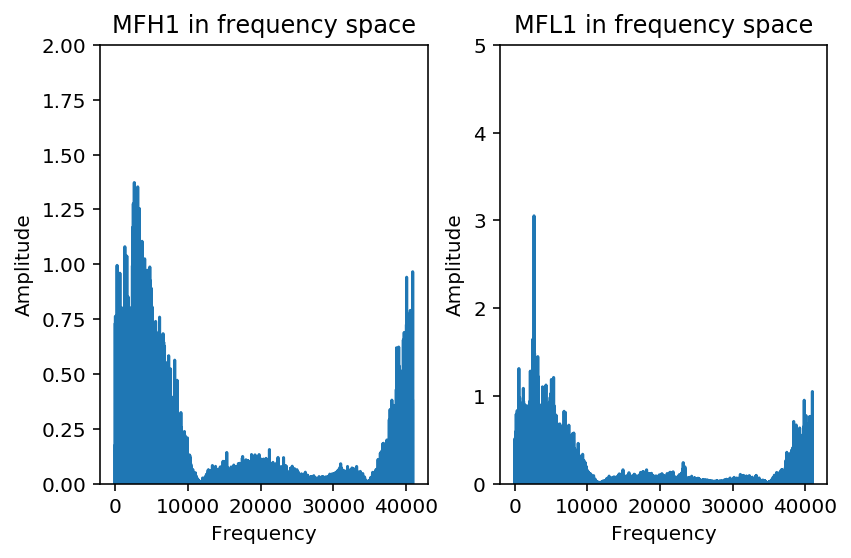

In [156]:
plt.subplot(1,2,1)
plt.plot(matched_irfft2)

plt.title('MFH1 in frequency space')
plt.tight_layout()
plt.ylim(0,2)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(1,2,2)
plt.plot(matched_irfft)
plt.title('MFL1 in frequency space')
plt.tight_layout()
plt.ylim(0,5)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.savefig('event2SNR.png')
plt.show()

In [581]:
print('SNR =',np.sum(np.abs((np.fft.rfft(windowedh1)))**2)/(np.sum(noise)))

('SNR =', 0.014954532555040421)


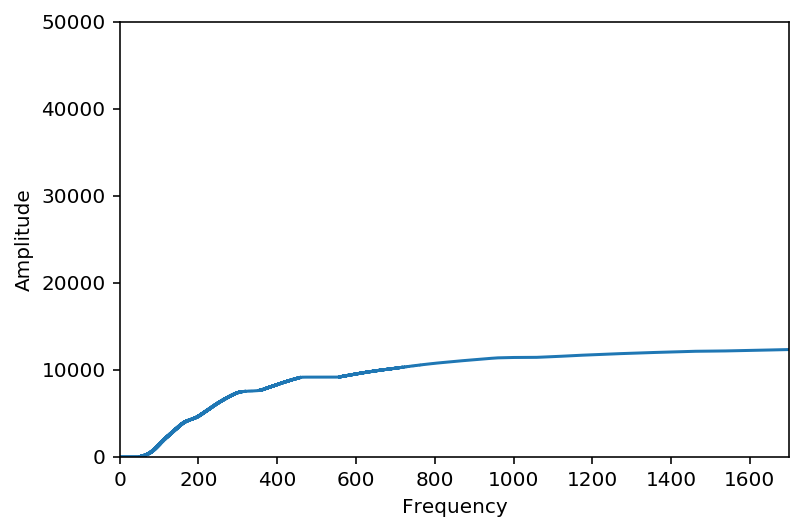

In [407]:
freq_H = np.fft.rfftfreq(th1.shape[-1], d=dt)
temp_sum_H = np.abs(np.cumsum(whitened_template))

plt.plot(freq_H,temp_sum_H)
plt.ylabel('Amplitude')
plt.xlim(0,1700)
plt.ylim(0,50000)
plt.xlabel('Frequency')
plt.savefig('CumsumEv2.png')

## Event 3

Reading in parameters for event LVT151012
{u'fband': [43.0, 400.0], u'approx': u'lalsim.SEOBNRv2', u'fs': 4096, u'name': u'LVT151012', u'utcevent': u'2015-10-12T09:54:43.44', u'fn_H1': u'H-H1_LOSC_4_V2-1128678884-32.hdf5', u'a1': 0.447, u'fn_L1': u'L-L1_LOSC_4_V2-1128678884-32.hdf5', u'm1': 44.111, u'f_min': 10.0, u'fn_template': u'LVT151012_4_template.hdf5', u'm2': 11.205, u'tevent': 1128678900.44, u'a2': -0.434}
('time_H1: len, min, mean, max = ', 131072, 1128678884.0, 1128678899.999878, 1128678915.9997559)
('strain_H1: len, min, mean, max = ', 131072, -8.590827401770376e-19, -2.8934952956460883e-22, 8.437113739365321e-19)
('strain_L1: len, min, mean, max = ', 131072, -3.880397433260277e-18, -1.0955608636862195e-18, 1.8973107919644716e-18)
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA
1128678900.44


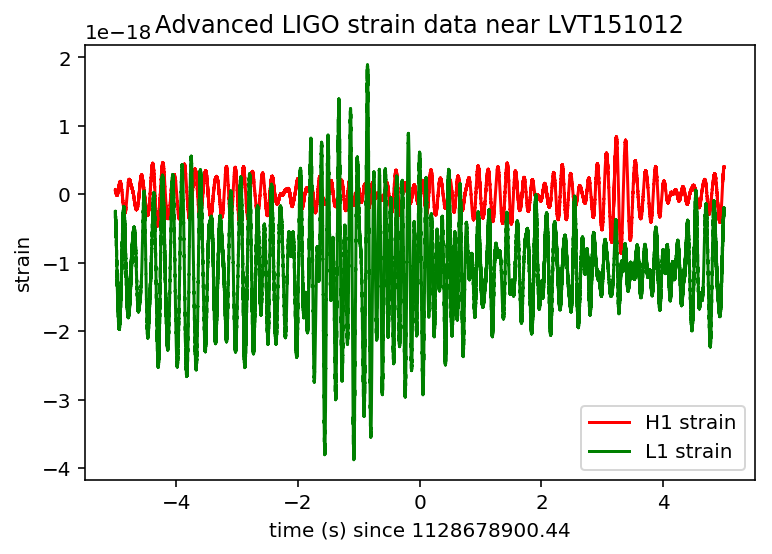

In [408]:
#-- SET ME   Tutorial should work with most binary black hole events
#-- Default is no event selection; you MUST select one to proceed.
#eventname = 'GW150914' 
#eventname = 'GW151226' 
eventname = 'LVT151012'
#eventname = 'GW170104'

# want plots?
make_plots = 1
plottype = "png"
#plottype = "pdf"

# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))

# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)    
    plt.savefig(eventname+'_strain.'+plottype)

(40960,)


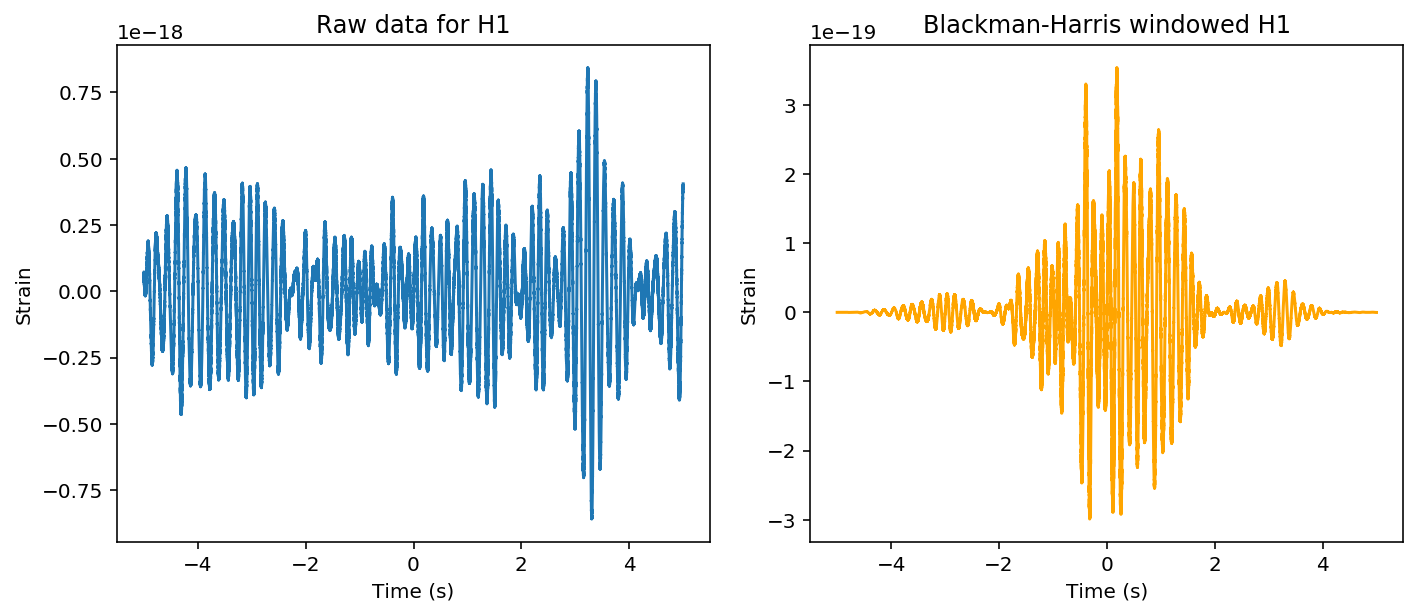

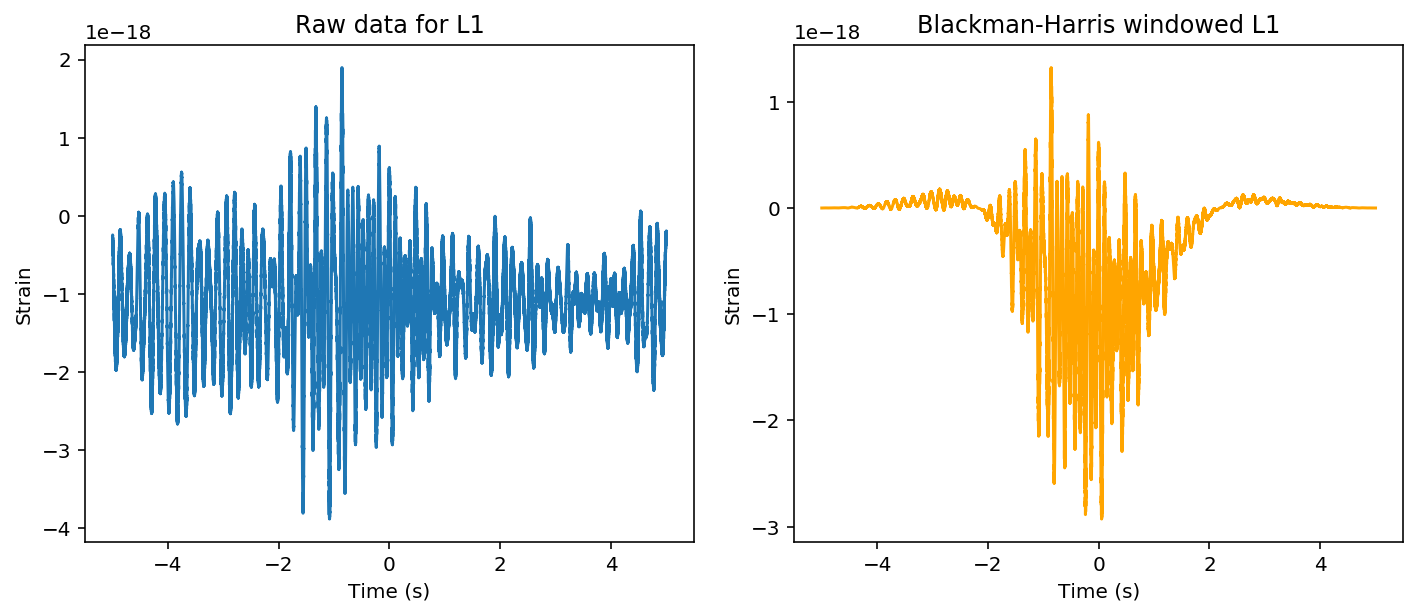

In [409]:
h1 = strain_H1[indxt]
print (np.shape(h1))
th1 = time[indxt]- tevent

l1 = strain_L1[indxt]
tl1 = time[indxt]- tevent


import numpy as np
import scipy
from scipy.signal import firwin, freqz, lfilter

def window(data, window_fn="hamming"):
    data = data * scipy.signal.get_window(window_fn,len(data))
    windowed_data = data
    return windowed_data

windowedh1 = window(h1, window_fn="flattop")
windowedl1 = window(l1,window_fn="flattop")
fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.plot(th1,h1)
plt.title("Raw data for H1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(th1,windowedh1,'orange')
plt.title("Blackman-Harris windowed H1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.show()

fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.plot(tl1,l1)
plt.title("Raw data for L1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(th1,windowedl1,'orange')
plt.title("Blackman-Harris windowed L1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.show()

## Hanford matched filter

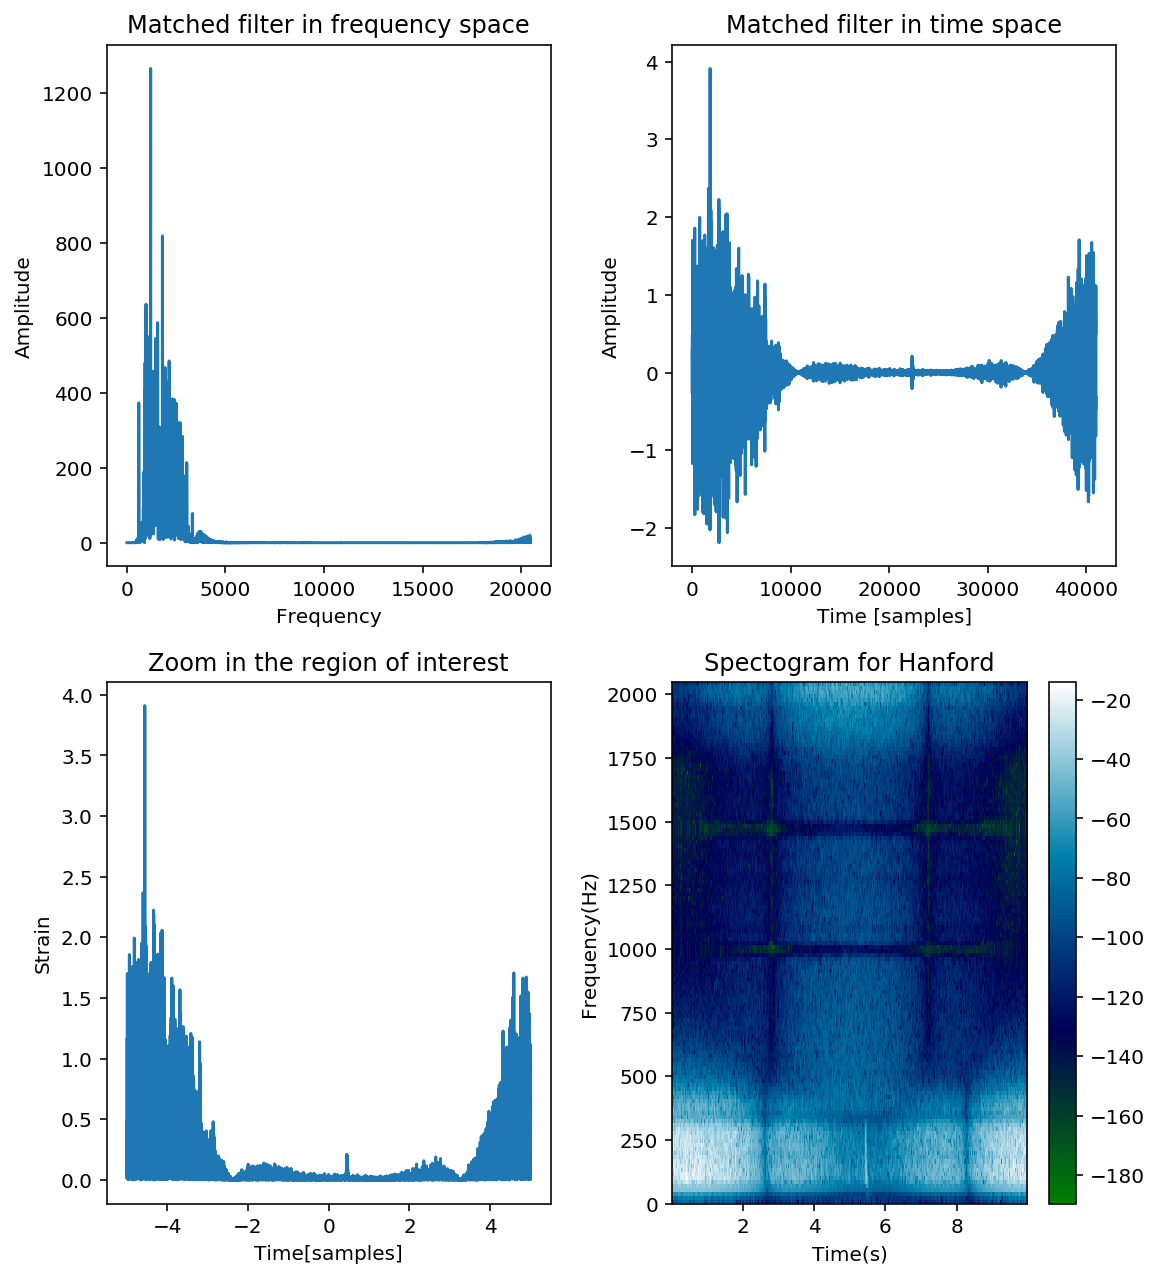

In [410]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()
    
bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

from scipy.ndimage import gaussian_filter

#Calculating the PSD of the windowed data 
psd_data = np.abs(np.fft.rfft(windowedh1))**2

def smoothing_data(data):
    data = gaussian_filter(data,100)
    return data

#Smooth the PSD -> This is my noise model!!
noise = smoothing_data(psd_data)

#Let us do the same thing about the template!
np.shape(template_p)
#Taking the Complex Conjugate
temp_fft = np.conj(np.fft.rfft(template_p[indxt]))

whitened_template = temp_fft/np.sqrt(noise)
whitened_data = np.fft.rfft(windowedh1)/(np.sqrt(noise))

matched_filter = whitened_template * whitened_data
matched_irfft = np.fft.irfft(matched_filter)

spec_cmap='ocean'

plt.figure(figsize=(8,9))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(2, 2, 1)
plt.plot(np.abs(matched_filter))
plt.title('Matched filter in frequency space')
plt.tight_layout()
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(matched_irfft)
plt.title('Matched filter in time space')
plt.xlabel('Time [samples]')
plt.tight_layout()
plt.ylabel('Amplitude')

plt.subplot(2, 2, 3)
plt.title('Zoom in the region of interest')
plt.plot(th1,np.abs(matched_irfft))
#plt.xlim(0,2000)
plt.tight_layout()
plt.xlabel('Time[samples]')
plt.tight_layout()
plt.ylabel('Strain')

# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = int(fs/16.0)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15/16.0)

window = signal.blackmanharris(NFFT)
plt.subplot(2,2,4)
plt.specgram(matched_irfft,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Hanford')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.tight_layout()
plt.colorbar()
plt.show()

## Livingston matched filter

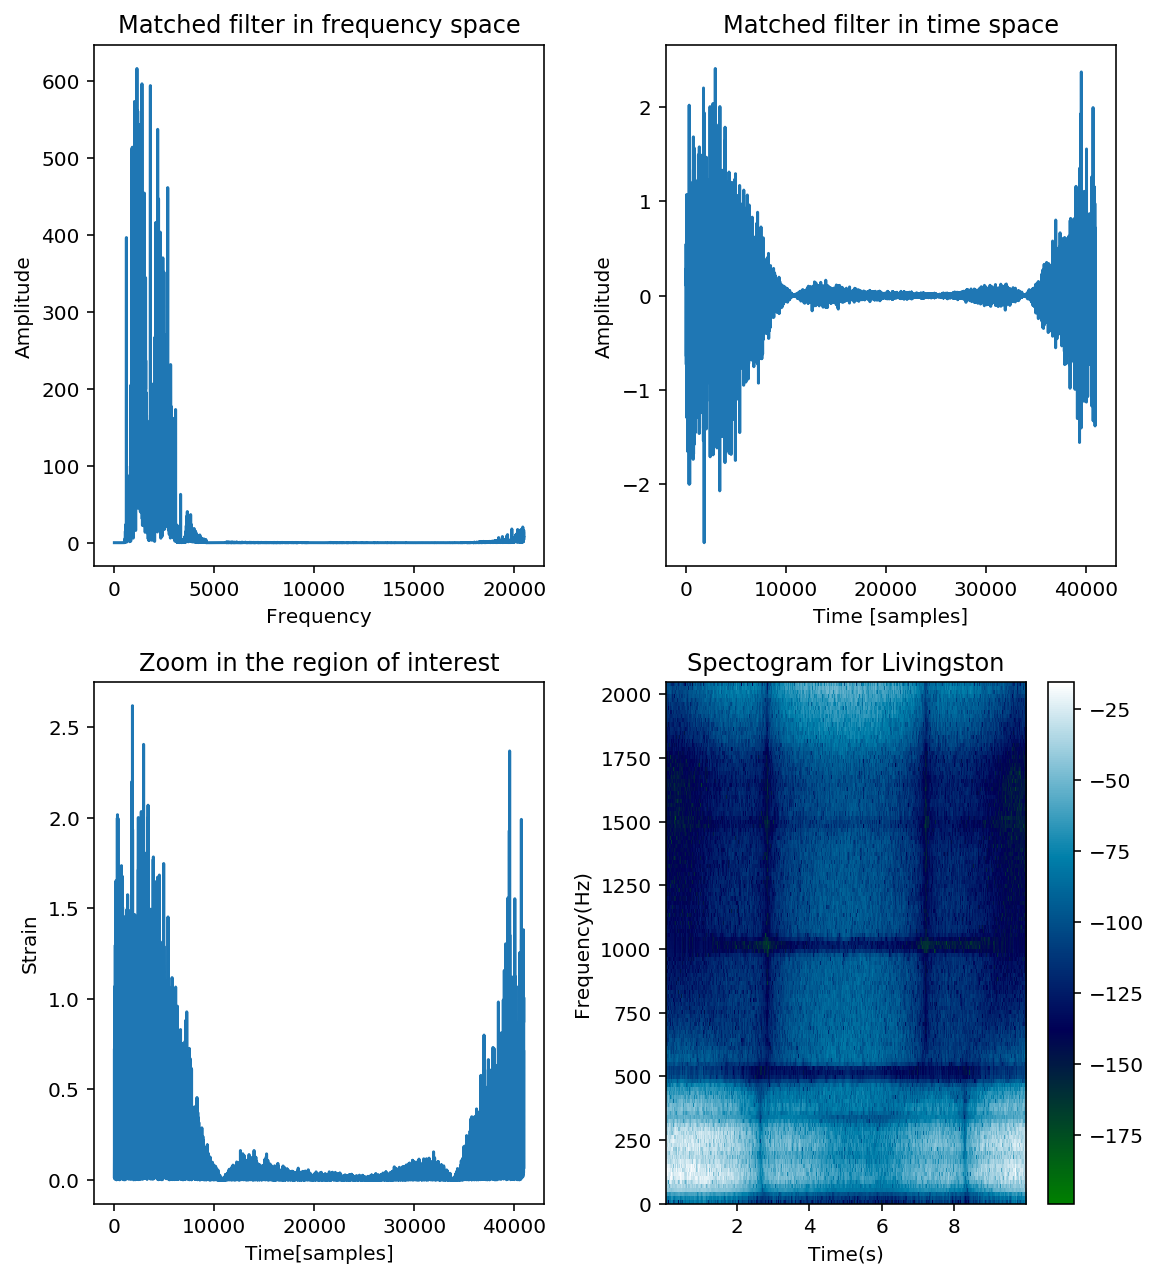

In [411]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()
    
bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

from scipy.ndimage import gaussian_filter

#Calculating the PSD of the windiwed data 
psd_data = signal.medfilt(np.abs(np.fft.rfft(windowedl1))**2)

def smoothing_data(data):
    data = gaussian_filter(data,100)
    return data

#Smooth the PSD -> This is my noise model!!
noise = smoothing_data(psd_data)

#Let us do the same thing about the template!
np.shape(template_p)
#Taking the Complex Conjugate
temp_fft = np.conj(np.fft.rfft(template_p[indxt]))

whitened_template = temp_fft/np.sqrt(noise)
whitened_data = np.fft.rfft(windowedl1)/(np.sqrt(noise))

matched_filter2 = np.conj((np.fft.rfft(template_p[indxt]))/np.sqrt(noise))* whitened_data
matched_irfft2 = np.fft.irfft(matched_filter2)

spec_cmap='ocean'

plt.figure(figsize=(8,9))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(2, 2, 1)
plt.plot(np.abs(matched_filter2))
plt.title('Matched filter in frequency space')
plt.tight_layout()
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(matched_irfft2)
plt.title('Matched filter in time space')
plt.xlabel('Time [samples]')
plt.tight_layout()
plt.ylabel('Amplitude')

plt.subplot(2, 2, 3)
plt.title('Zoom in the region of interest')
plt.plot(np.abs(matched_irfft2))
plt.tight_layout()
plt.xlabel('Time[samples]')
plt.tight_layout()
plt.ylabel('Strain')

# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = int(fs/16.0)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15/16.0)

window = signal.blackmanharris(NFFT)
plt.subplot(2,2,4)
plt.specgram(matched_irfft2,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Livingston')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.tight_layout()
plt.colorbar()
plt.show()

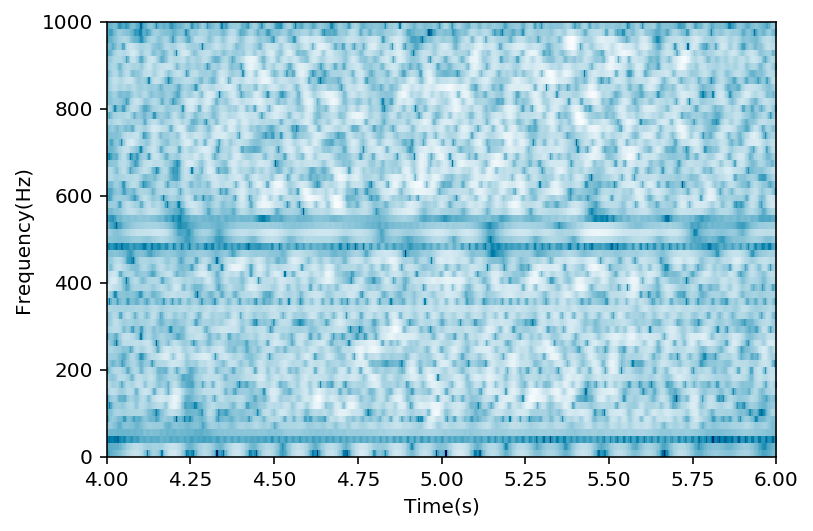

In [412]:
plt.specgram(np.fft.irfft(whitened_data),Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.xlabel('Time(s)')
plt.xlim(4,6)
plt.ylim(0,1000)
plt.ylabel('Frequency(Hz)')
plt.show()

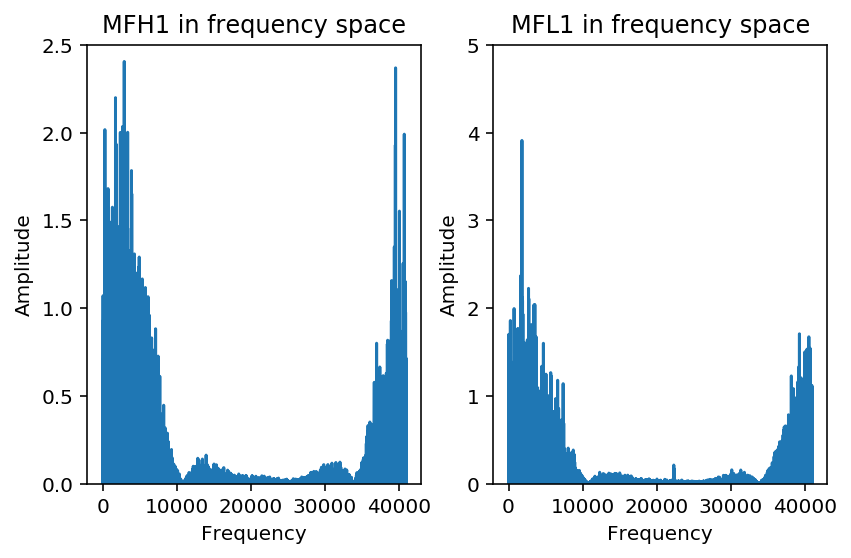

In [413]:
plt.subplot(1,2,1)
plt.plot(matched_irfft2)

plt.title('MFH1 in frequency space')
plt.tight_layout()
plt.ylim(0,2.5)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(1,2,2)
plt.plot(matched_irfft)
plt.title('MFL1 in frequency space')
plt.tight_layout()
plt.ylim(0,5)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.savefig('event3SNR.png')
plt.show()

In [603]:
np.sum(np.abs(np.fft.rfft(windowedh1))**2)/(np.sum(noise))

0.016035309569973868

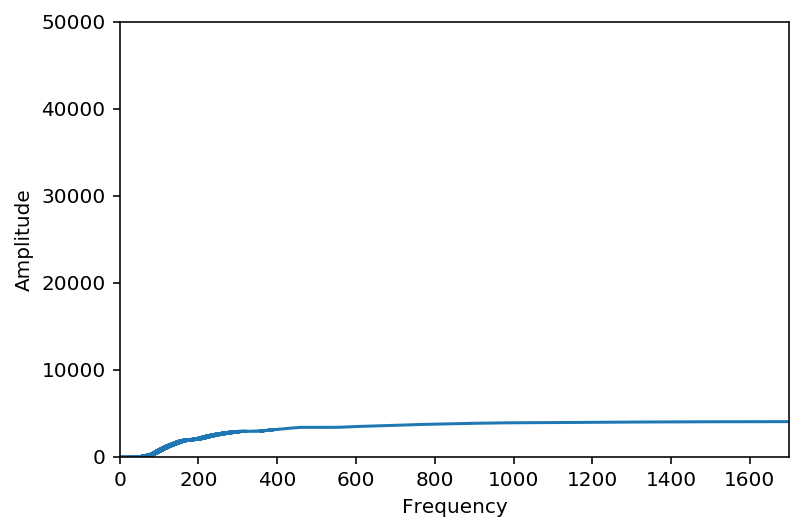

In [414]:
freq_H = np.fft.rfftfreq(th1.shape[-1], d=dt)
temp_sum_H = np.abs(np.cumsum(whitened_template))

plt.plot(freq_H,temp_sum_H)
plt.ylabel('Amplitude')
plt.xlim(0,1700)
plt.ylim(0,50000)
plt.xlabel('Frequency')
plt.savefig('CumsumEv3.png')

## Event 4

Reading in parameters for event GW170104
{u'fband': [43.0, 800.0], u'approx': u'lalsim.SEOBNRv2', u'fs': 4096, u'name': u'GW170104', u'utcevent': u'2017-01-04T10:11:58.60', u'fn_H1': u'H-H1_LOSC_4_V1-1167559920-32.hdf5', u'a1': -0.236, u'fn_L1': u'L-L1_LOSC_4_V1-1167559920-32.hdf5', u'm1': 33.64, u'f_min': 10.0, u'fn_template': u'GW170104_4_template.hdf5', u'm2': 24.82, u'tevent': 1167559936.6, u'a2': 0.024}
('time_H1: len, min, mean, max = ', 131072, 1167559920.0, 1167559935.999878, 1167559951.9997559)
('strain_H1: len, min, mean, max = ', 131072, -9.764594393999979e-19, -1.2428210976648e-21, 9.978458002427874e-19)
('strain_L1: len, min, mean, max = ', 131072, -2.5975507121314415e-18, -1.45964286124064e-18, -3.017557329612972e-19)
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA
1167559936.6


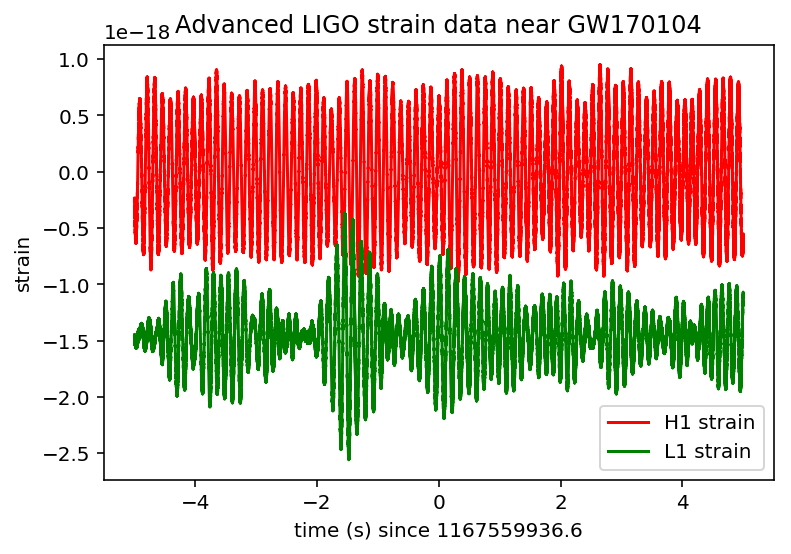

In [224]:
#-- SET ME   Tutorial should work with most binary black hole events
#-- Default is no event selection; you MUST select one to proceed.
#eventname = 'GW150914' 
#eventname = 'GW151226' 
#eventname = 'LVT151012'
eventname = 'GW170104'

# want plots?
make_plots = 1
plottype = "png"
#plottype = "pdf"

# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))

# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)    
    plt.savefig(eventname+'_strain.'+plottype)

(40960,)


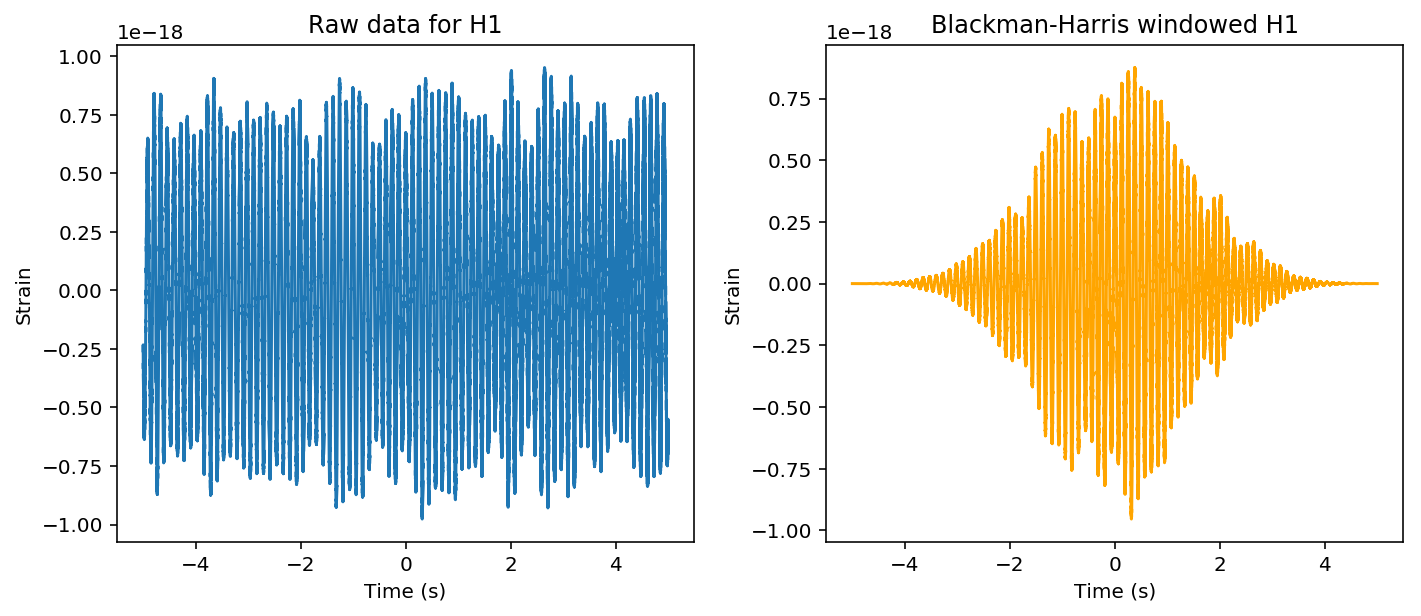

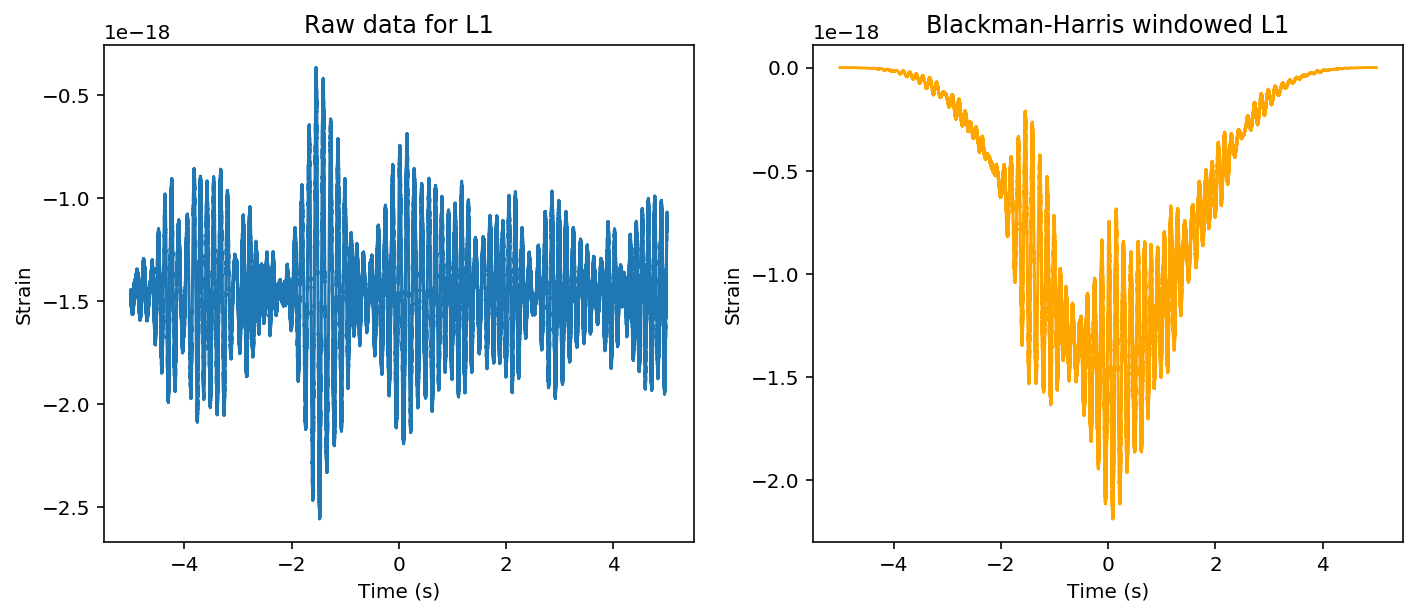

In [225]:
import numpy as np
import scipy
from scipy.signal import firwin, freqz, lfilter

h1 = strain_H1[indxt]
print (np.shape(h1))
th1 = time[indxt]- tevent

l1 = strain_L1[indxt]
tl1 = time[indxt]- tevent

def window(data, window_fn="hamming"):
    data = data * scipy.signal.get_window(window_fn,len(data))
    windowed_data = data
    return windowed_data

windowedh1 = window(h1, window_fn="blackmanharris")
windowedl1 = window(l1,window_fn="blackmanharris")
fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.plot(th1,h1)
plt.title("Raw data for H1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(th1,windowedh1,'orange')
plt.title("Blackman-Harris windowed H1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.show()

fig = plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.plot(tl1,l1)
plt.title("Raw data for L1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(th1,windowedl1,'orange')
plt.title("Blackman-Harris windowed L1")
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.tight_layout()

plt.show()

## Hanford matched filter

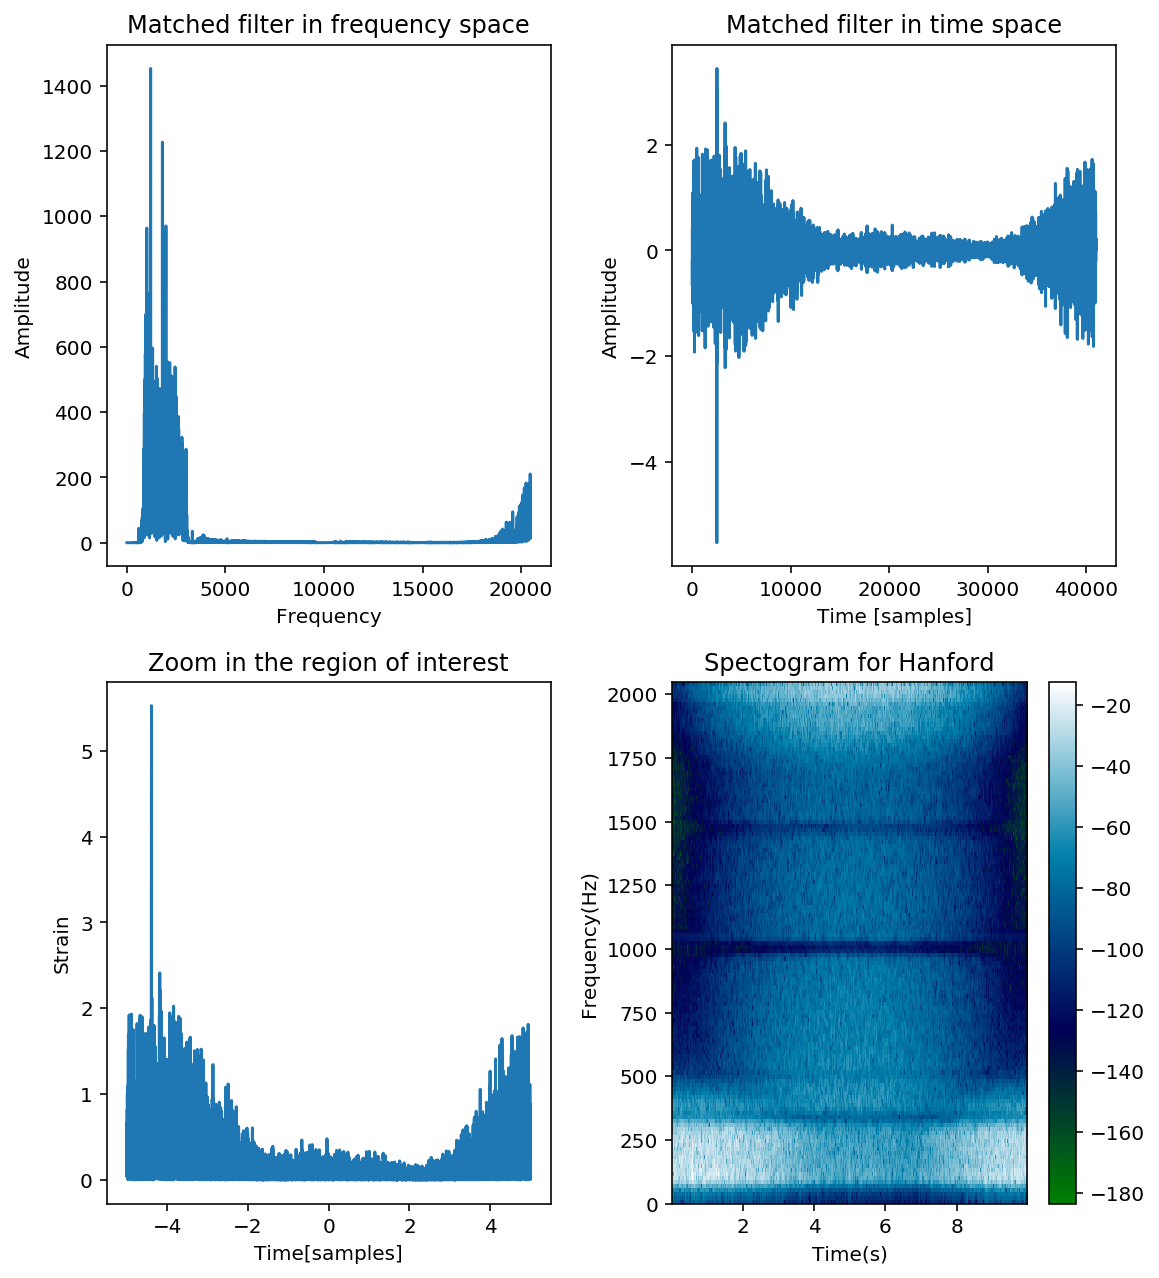

In [226]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()
    
bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

from scipy.ndimage import gaussian_filter

#Calculating the PSD of the windowed data 
psd_data = np.abs(np.fft.rfft(windowedh1))**2

def smoothing_data(data):
    data = gaussian_filter(data,100)
    return data

#Smooth the PSD -> This is my noise model!!
noise = smoothing_data(psd_data)

#Let us do the same thing about the template!
np.shape(template_p)
#Taking the Complex Conjugate
temp_fft = np.conj(np.fft.rfft(template_p[indxt]))

whitened_template = temp_fft/np.sqrt(noise)
whitened_data = np.fft.rfft(windowedh1)/(np.sqrt(noise))

matched_filter = whitened_template * whitened_data
matched_irfft = np.fft.irfft(matched_filter)

spec_cmap='ocean'

plt.figure(figsize=(8,9))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(2, 2, 1)
plt.plot(np.abs(matched_filter))
plt.title('Matched filter in frequency space')
plt.tight_layout()
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(matched_irfft)
plt.title('Matched filter in time space')
plt.xlabel('Time [samples]')
plt.tight_layout()
plt.ylabel('Amplitude')

plt.subplot(2, 2, 3)
plt.title('Zoom in the region of interest')
plt.plot(th1,np.abs(matched_irfft))
#plt.xlim(0,2000)
plt.tight_layout()
plt.xlabel('Time[samples]')
plt.tight_layout()
plt.ylabel('Strain')

# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = int(fs/16.0)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15/16.0)

window = signal.blackmanharris(NFFT)
plt.subplot(2,2,4)
plt.specgram(matched_irfft,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Hanford')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.tight_layout()
plt.colorbar()
plt.show()

## Livingston matched filter

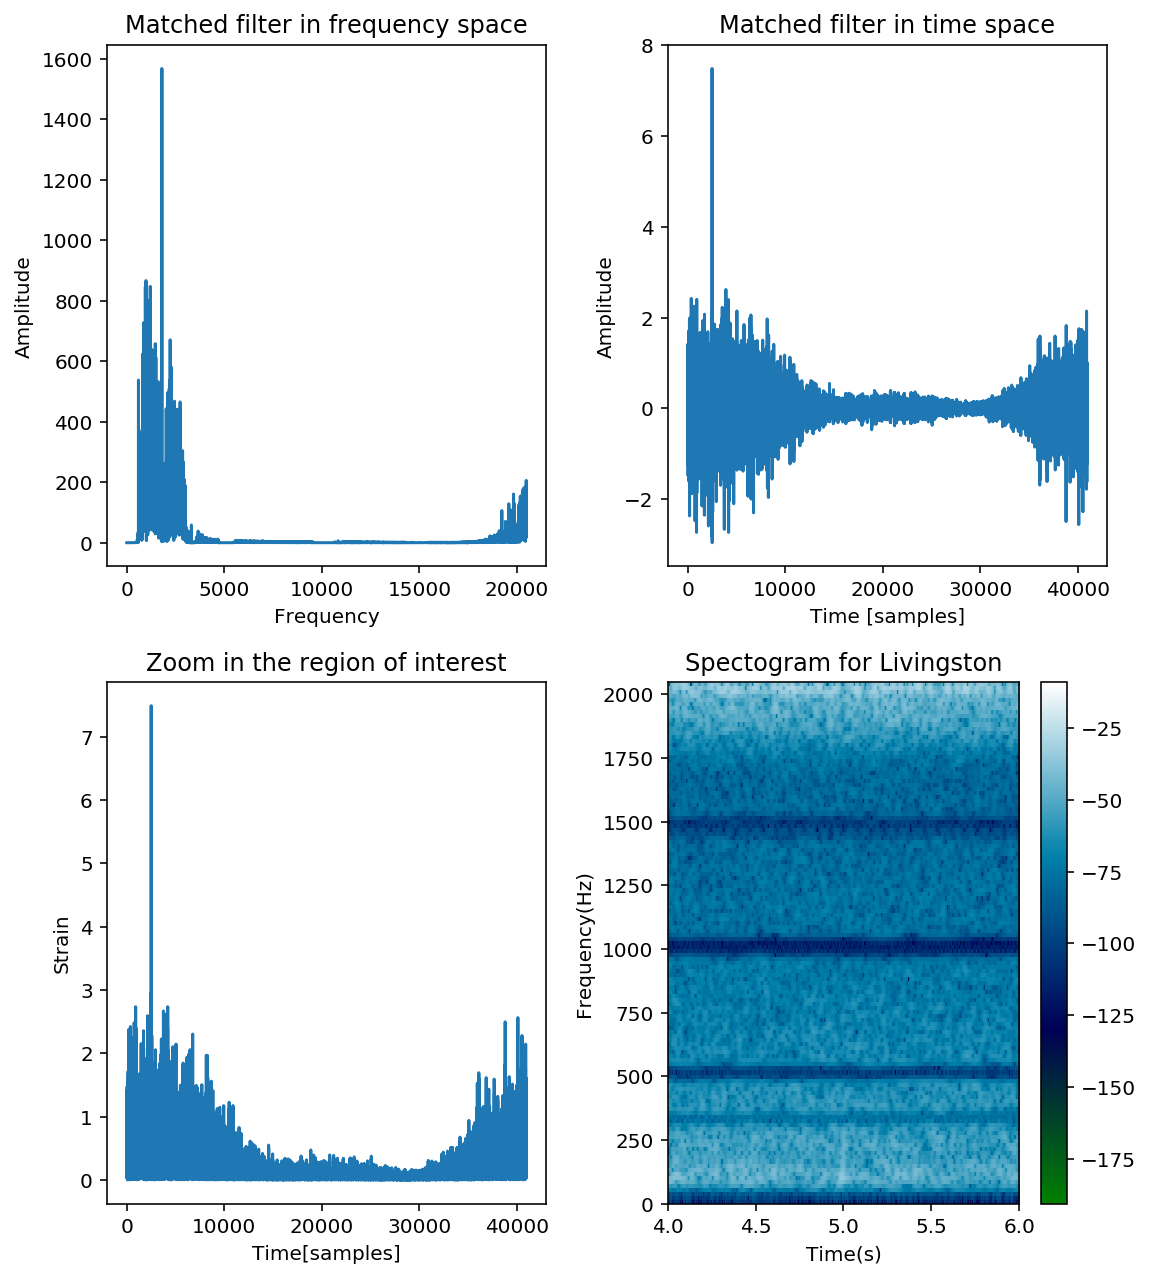

In [227]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()
    
bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
normalization = np.sqrt((fband[1]-fband[0])/(fs/2))

template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

from scipy.ndimage import gaussian_filter

#Calculating the PSD of the windiwed data 
psd_data = signal.medfilt(np.abs(np.fft.rfft(windowedl1))**2)

def smoothing_data(data):
    data = gaussian_filter(data,100)
    return data

#Smooth the PSD -> This is my noise model!!
noise = smoothing_data(psd_data)

#Let us do the same thing about the template!
np.shape(template_p)
#Taking the Complex Conjugate
temp_fft = np.conj(np.fft.rfft(template_p[indxt]))

whitened_template = temp_fft/np.sqrt(noise)
whitened_data = np.fft.rfft(windowedl1)/(np.sqrt(noise))

matched_filter2 = np.conj((np.fft.rfft(template_p[indxt]))/np.sqrt(noise))* whitened_data
matched_irfft2 = np.fft.irfft(matched_filter2)

spec_cmap='ocean'

plt.figure(figsize=(8,9))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(2, 2, 1)
plt.plot(np.abs(matched_filter2))
plt.title('Matched filter in frequency space')
plt.tight_layout()
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(matched_irfft2)
plt.title('Matched filter in time space')
plt.xlabel('Time [samples]')
plt.tight_layout()
plt.ylabel('Amplitude')

plt.subplot(2, 2, 3)
plt.title('Zoom in the region of interest')
plt.plot(np.abs(matched_irfft2))
plt.tight_layout()
plt.xlabel('Time[samples]')
plt.tight_layout()
plt.ylabel('Strain')

# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = int(fs/16.0)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15/16.0)

window = signal.blackmanharris(NFFT)
plt.subplot(2,2,4)
plt.specgram(matched_irfft2,Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.title('Spectogram for Livingston')
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.xlim(4,6)
plt.tight_layout()
plt.colorbar()
plt.show()

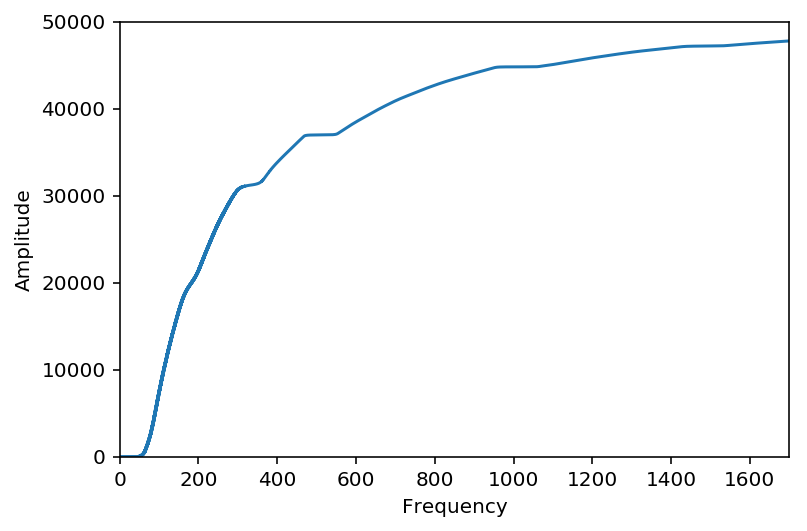

In [376]:
freq_H = np.fft.rfftfreq(th1.shape[-1], d=dt)
temp_sum_H = np.abs(np.cumsum(whitened_template))

plt.plot(freq_H,temp_sum_H)
plt.ylabel('Amplitude')
plt.xlim(0,1700)
plt.ylim(0,50000)
plt.xlabel('Frequency')
plt.savefig('CumsumEv4.png')

In [241]:
for i in range(len(fname_H)):
    # take the template for H and L in the fourier space, and take the power spectrum of that
    tempH = np.abs(templatesFT_white_H[i])**2
    tempL = np.abs(templatesFT_white_L[i])**2
    # compute cumulative sum
    temp_sum_H = np.cumsum(tempH)
    temp_sum_L = np.cumsum(tempL)
    # plot the results for each detector
    plt.figure()
    plt.step(frequency_H[i],temp_sum_H,label='H')
    plt.step(frequency_L[i],temp_sum_L,label='L')
    plt.title(GWs[i])
    plt.legend(loc='best')
    plt.xlabel('Frequency')
    plt.ylabel('Template cumulative sum')
    # compute the frequency value
    half_freq_H = findfrequency(temp_sum_H,frequency_H[i])
    half_freq_L = findfrequency(temp_sum_L,frequency_L[i])
    plt.axvline(x=half_freq_H,color='black',label='Half maximum for H')
    plt.axvline(x=half_freq_L,color='black',linestyle='--',label='Half maximum for L')
    plt.legend(loc='best')

NameError: name 'fname_H' is not defined

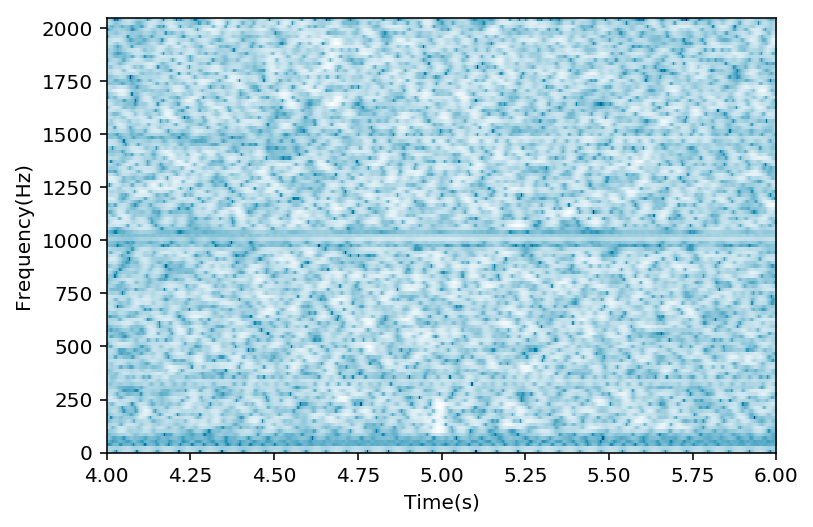

In [198]:
plt.specgram(np.fft.irfft(whitened_data),Fs=4096,cmap=spec_cmap,NFFT=NFFT,noverlap = NOVL)
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.xlim(4,6)
plt.show()

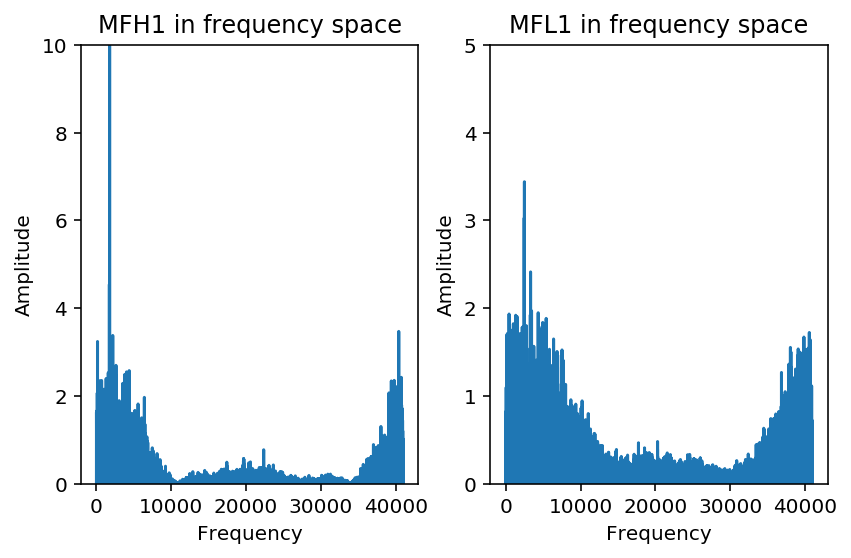

In [199]:
plt.subplot(1,2,1)
plt.plot(matched_irfft2)

plt.title('MFH1 in frequency space')
plt.tight_layout()
plt.ylim(0,10)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.subplot(1,2,2)
plt.plot(matched_irfft)
plt.title('MFL1 in frequency space')
plt.tight_layout()
plt.ylim(0,5)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.savefig('event4SNR.png')
plt.show()

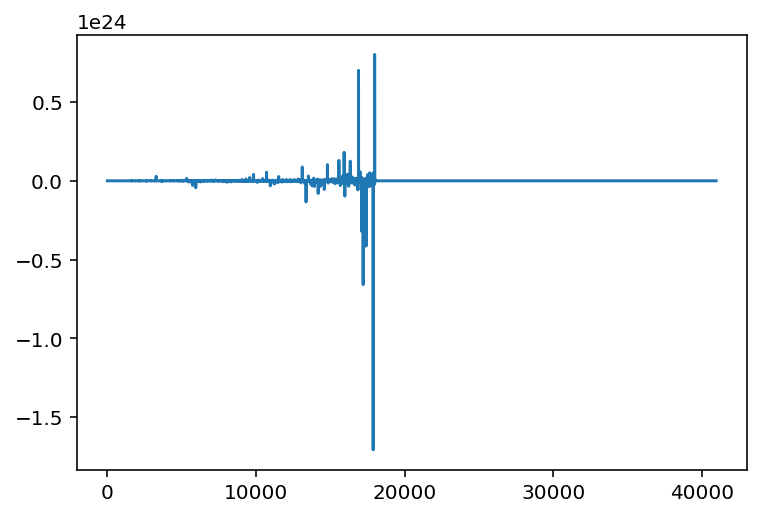

In [213]:
plt.plot((template_p[indxt])/(np.fft.irfft(noise)))

In [255]:
import numpy
from matplotlib import pyplot as plt
import h5py
import glob
plt.ion()

def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'].value
    #print meta.keys()
    utc=meta['UTCstart'].value
    duration=meta['Duration'].value
    strain=dataFile['strain']['Strain'].value
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc



#fnames=glob.glob("[HL]-*.hdf5")
#fname=fnames[0]
fname='H-H1_LOSC_4_V2-1126259446-32.hdf5'
print 'reading file ',fname
strain,dt,utc=read_file(fname)

#th,tl=read_template('GW150914_4_template.hdf5')
template_name='GW150914_4_template.hdf5'
th,tl=read_template(template_name)


#spec,nu=measure_ps(strain,do_win=True,dt=dt,osamp=16)
#strain_white=noise_filter(strain,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)

#th_white=noise_filter(th,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)
#tl_white=noise_filter(tl,numpy.sqrt(spec),nu,nu_max=1600.,taper=5000)


#matched_filt_h=numpy.fft.irfft(numpy.fft.rfft(strain_white)*numpy.conj(numpy.fft.rfft(th_white)))
#matched_filt_l=numpy.fft.irfft(numpy.fft.rfft(strain_white)*numpy.conj(numpy.fft.rfft(tl_white)))


#copied from bash from class
# strain2=np.append(strain,np.flipud(strain[1:-1]))
# tobs=len(strain)*dt
# k_true=np.arange(len(myft))*dnu

reading file  H-H1_LOSC_4_V2-1126259446-32.hdf5


/home/matheus/.local/lib/python2.7/site-packages/ipykernel_launcher.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/matheus/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/matheus/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/home/matheus/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
